In [1]:
import awkward as ak
import matplotlib.pyplot as plt
import os, sys
import subprocess
import json
import uproot
from coffea.nanoevents import NanoEventsFactory #, ScoutingNanoAODSchema
from coffea.lookup_tools.lookup_base import lookup_base
import numpy as np
from coffea import processor, util
from hist import Hist
import hist
from coffea.analysis_tools import Weights, PackedSelection
from collections import defaultdict
import mplhep
plt.style.use(mplhep.style.CMS)

In [2]:
old = util.load("outfiles/Run3Summer22/lumi986/nomuoniso/cutflow_Run2022D.coffea")
oldIsoTrack = util.load("outfiles/Run3Summer22/lumi25000hltmu50/cutflow_Run2022D_HLT_Mu50_CHS0.coffea")
isoTrack = util.load("outfiles/Run3Summer22/lumi25000hltmu50/nminus1_Run2022D_HLT_Mu50_old.coffea")[0]

In [5]:
h_old = old["cutflow"][{
    "pn_Hbb" : slice(0j, 1j, sum),
    "cat" : sum,
    "dataset" : sum,
}]

h_isoTrack = isoTrack["cutflow"][{
    "pn_Hbb" : slice(0j, 1j, sum),
    "cat" : sum,
    "dataset" : sum,
    "region" : hist.loc("all")
}]

/tmp/ipykernel_73/1894118431.py:54: RuntimeWarning: divide by zero encountered in divide
  rsumw = sumw_num / np.maximum(0, sumw_denom)
/tmp/ipykernel_73/1894118431.py:57: RuntimeWarning: divide by zero encountered in divide
  sumw2_num / sumw_denom**2
/srv/.env/lib/python3.8/site-packages/coffea/hist/plot.py:38: RuntimeWarning: invalid value encountered in divide
  scale[sumw != 0] = sumw2[sumw != 0] / sumw[sumw != 0]
/tmp/ipykernel_73/1894118431.py:54: RuntimeWarning: divide by zero encountered in divide
  rsumw = sumw_num / np.maximum(0, sumw_denom)
/tmp/ipykernel_73/1894118431.py:57: RuntimeWarning: divide by zero encountered in divide
  sumw2_num / sumw_denom**2
/srv/.env/lib/python3.8/site-packages/coffea/hist/plot.py:38: RuntimeWarning: invalid value encountered in divide
  scale[sumw != 0] = sumw2[sumw != 0] / sumw[sumw != 0]
/tmp/ipykernel_73/1894118431.py:54: RuntimeWarning: divide by zero encountered in divide
  rsumw = sumw_num / np.maximum(0, sumw_denom)
/tmp/ipykernel_73/

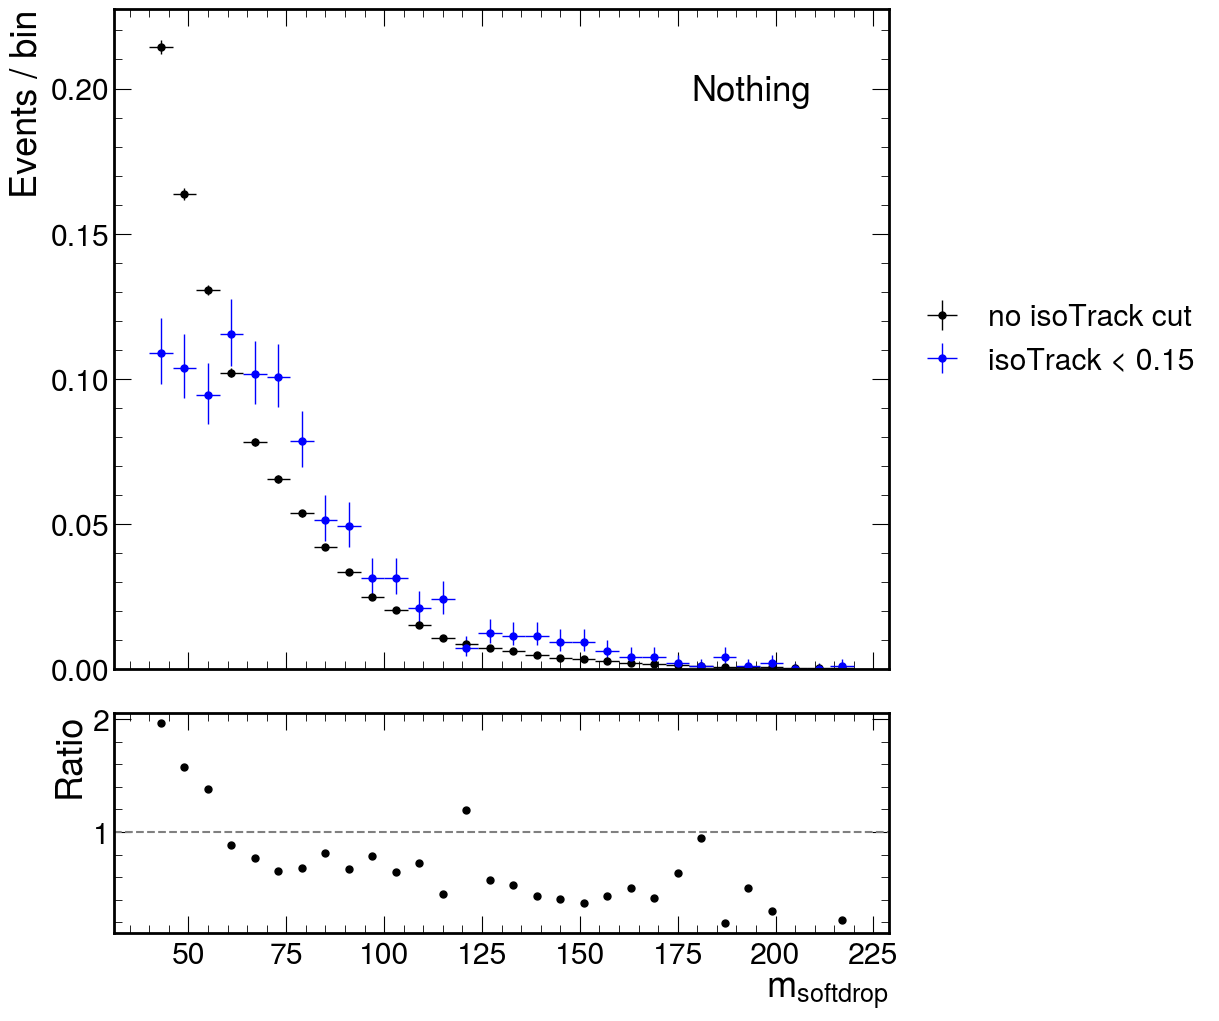

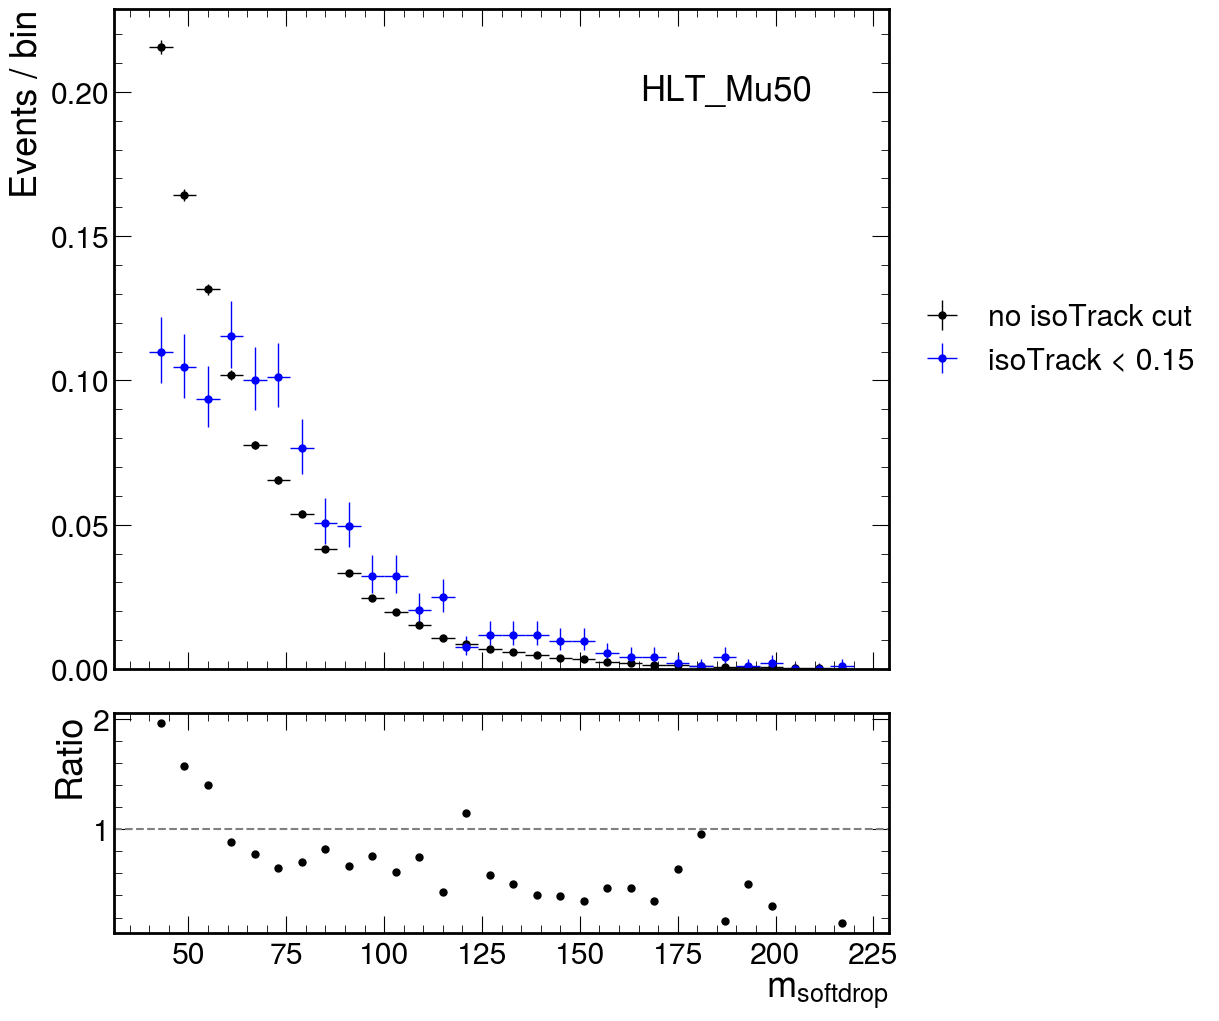

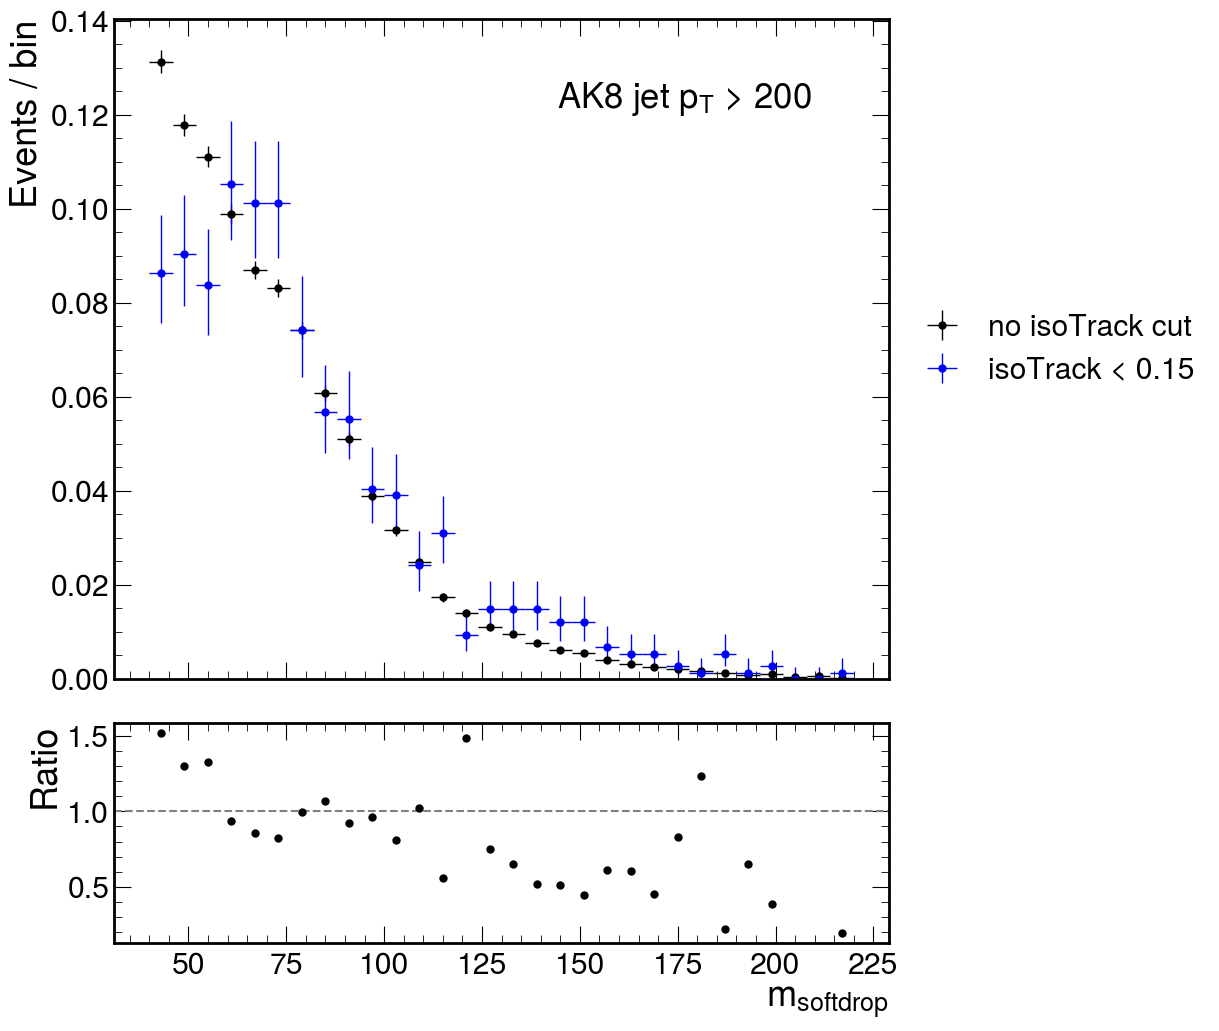

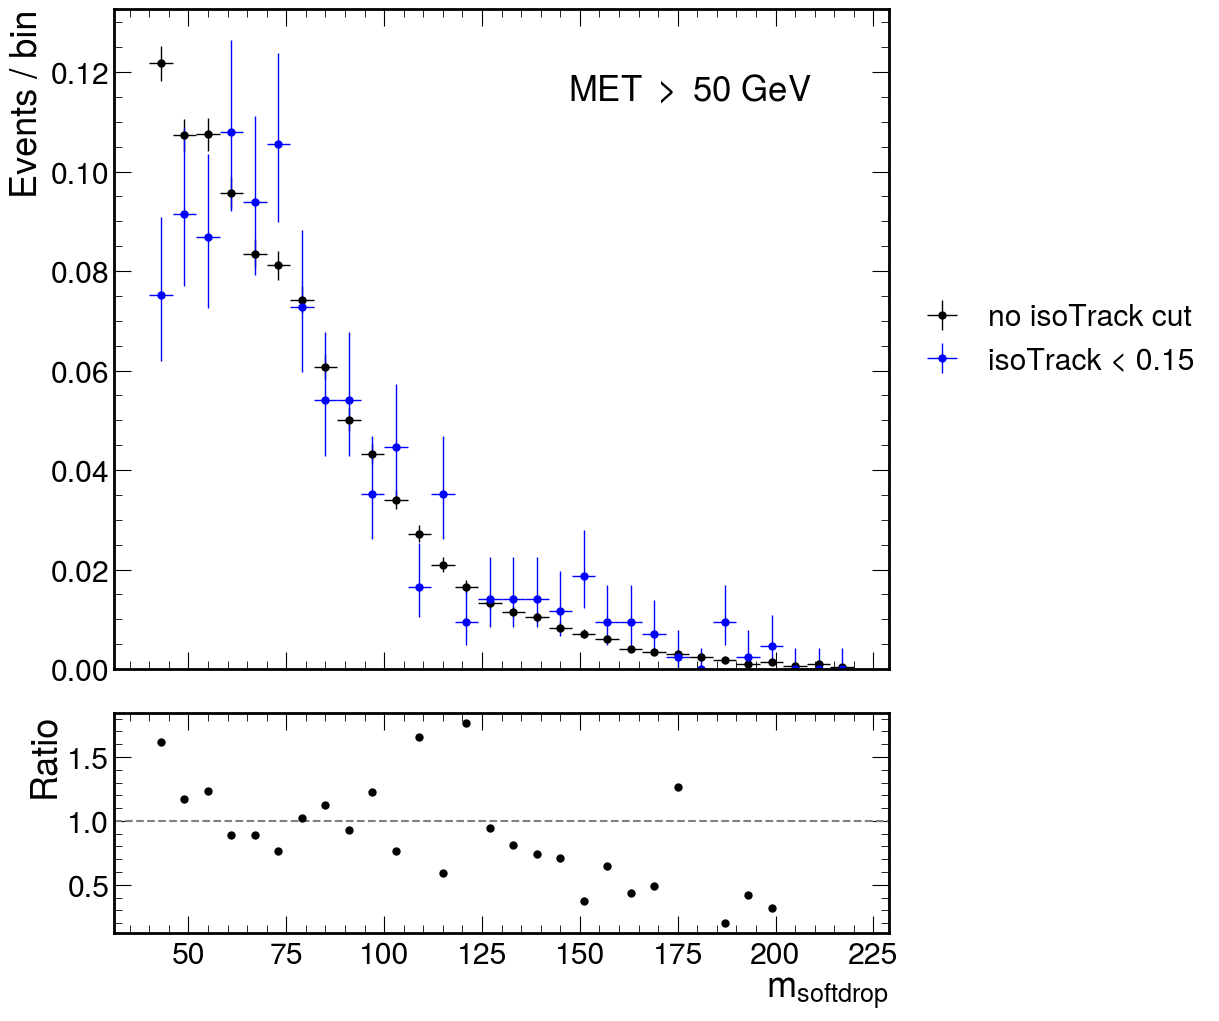

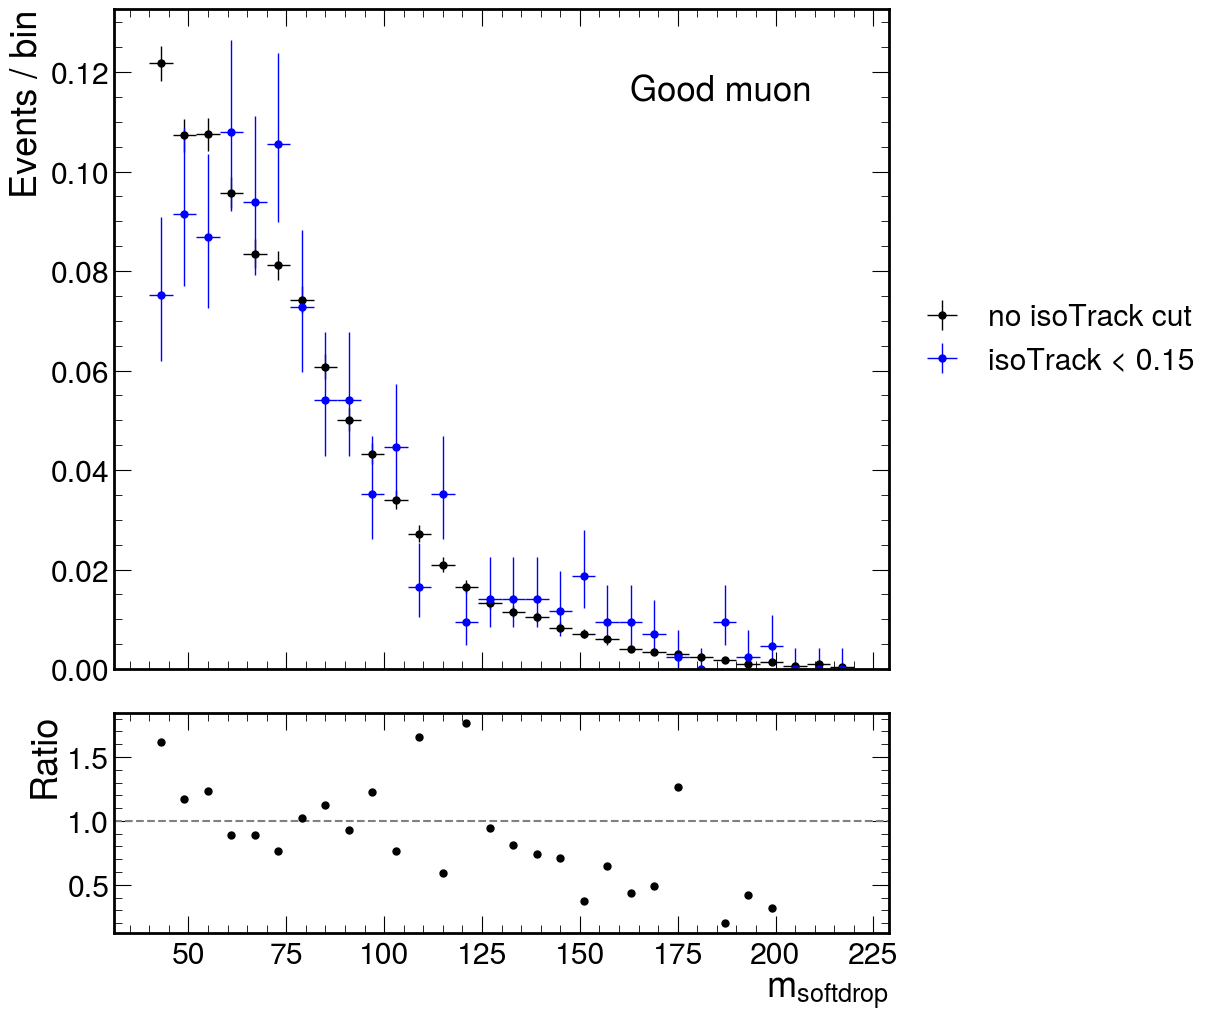

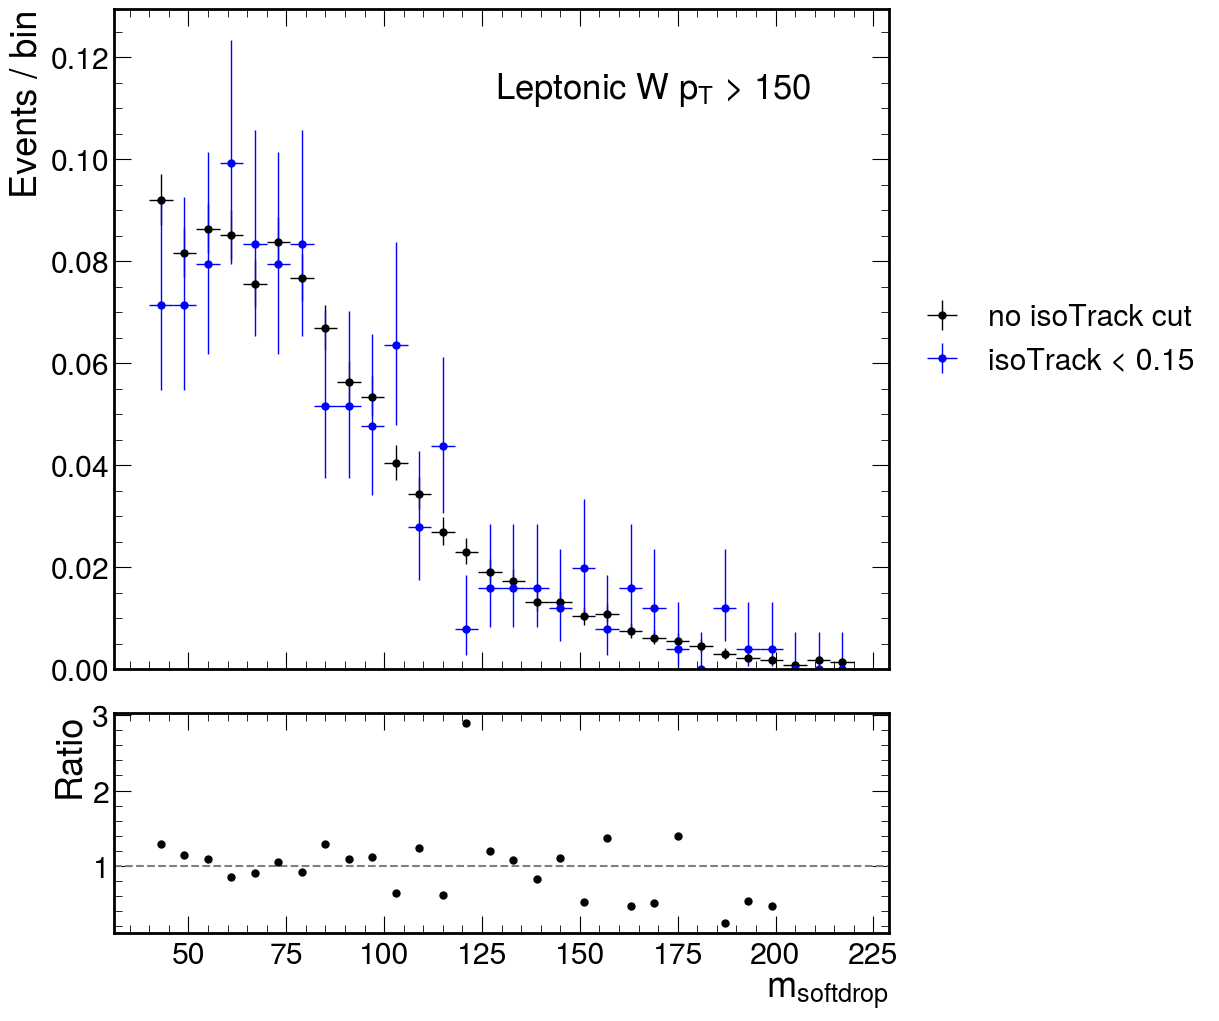

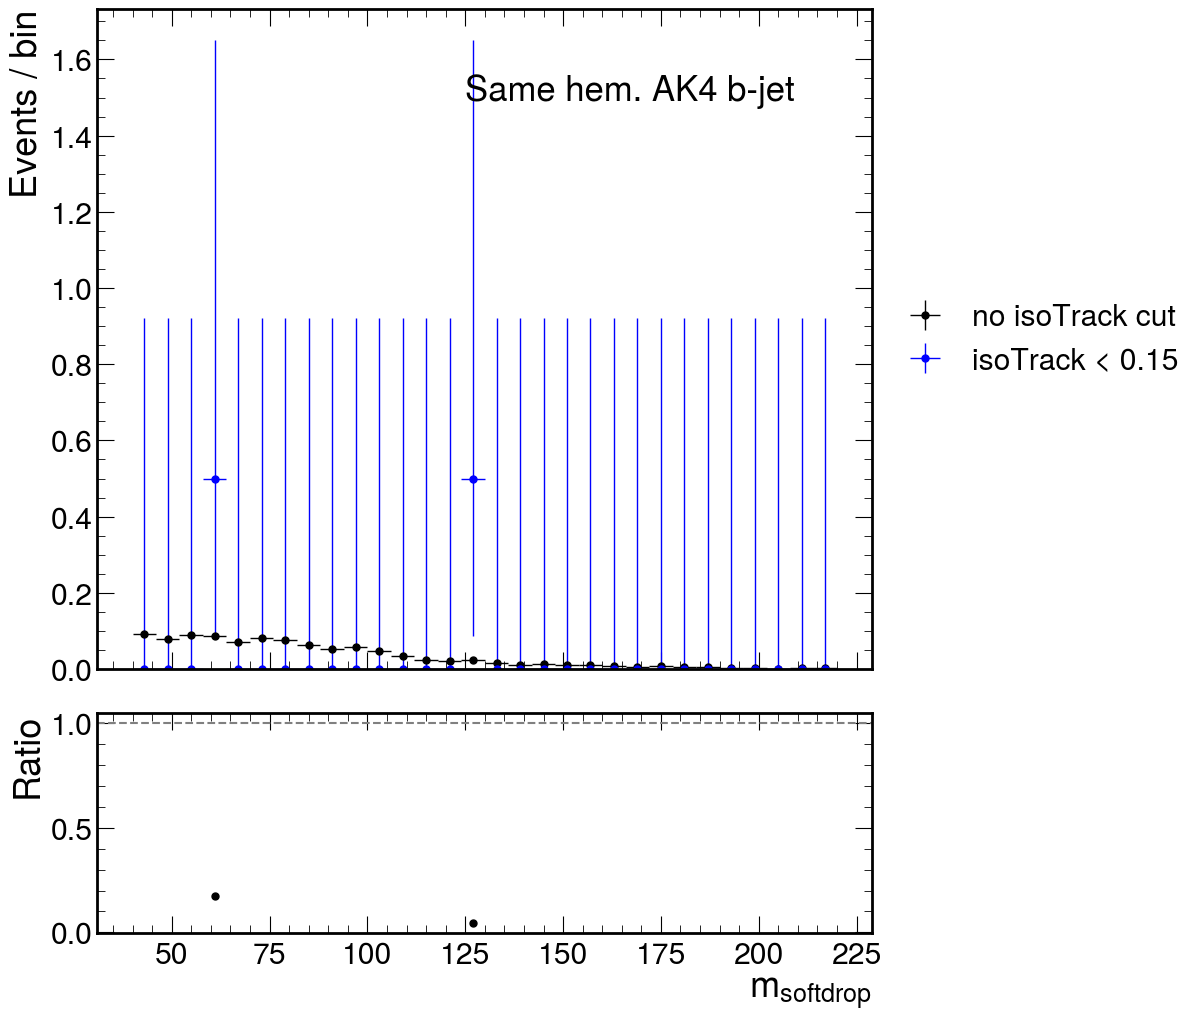

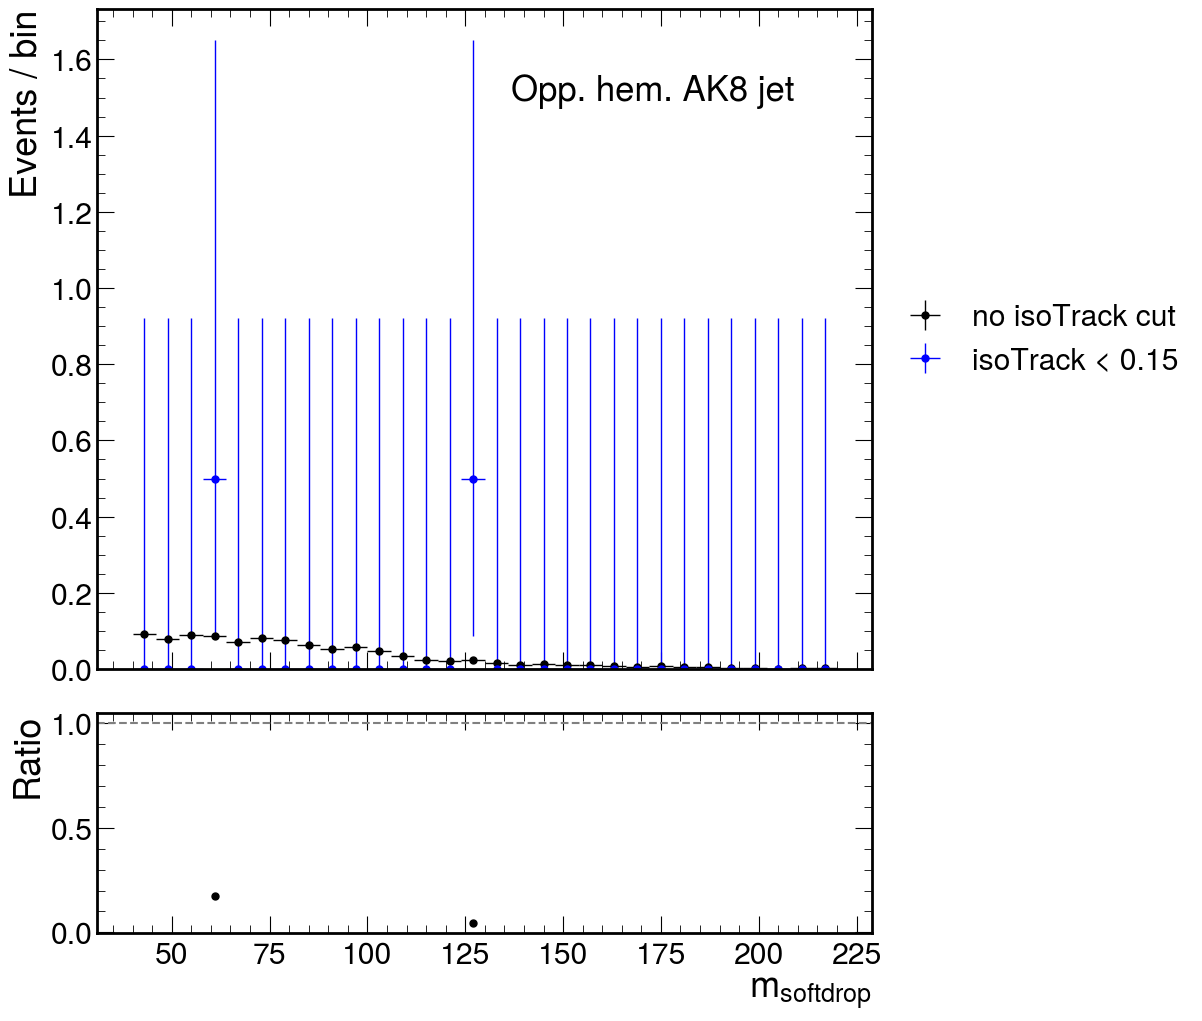

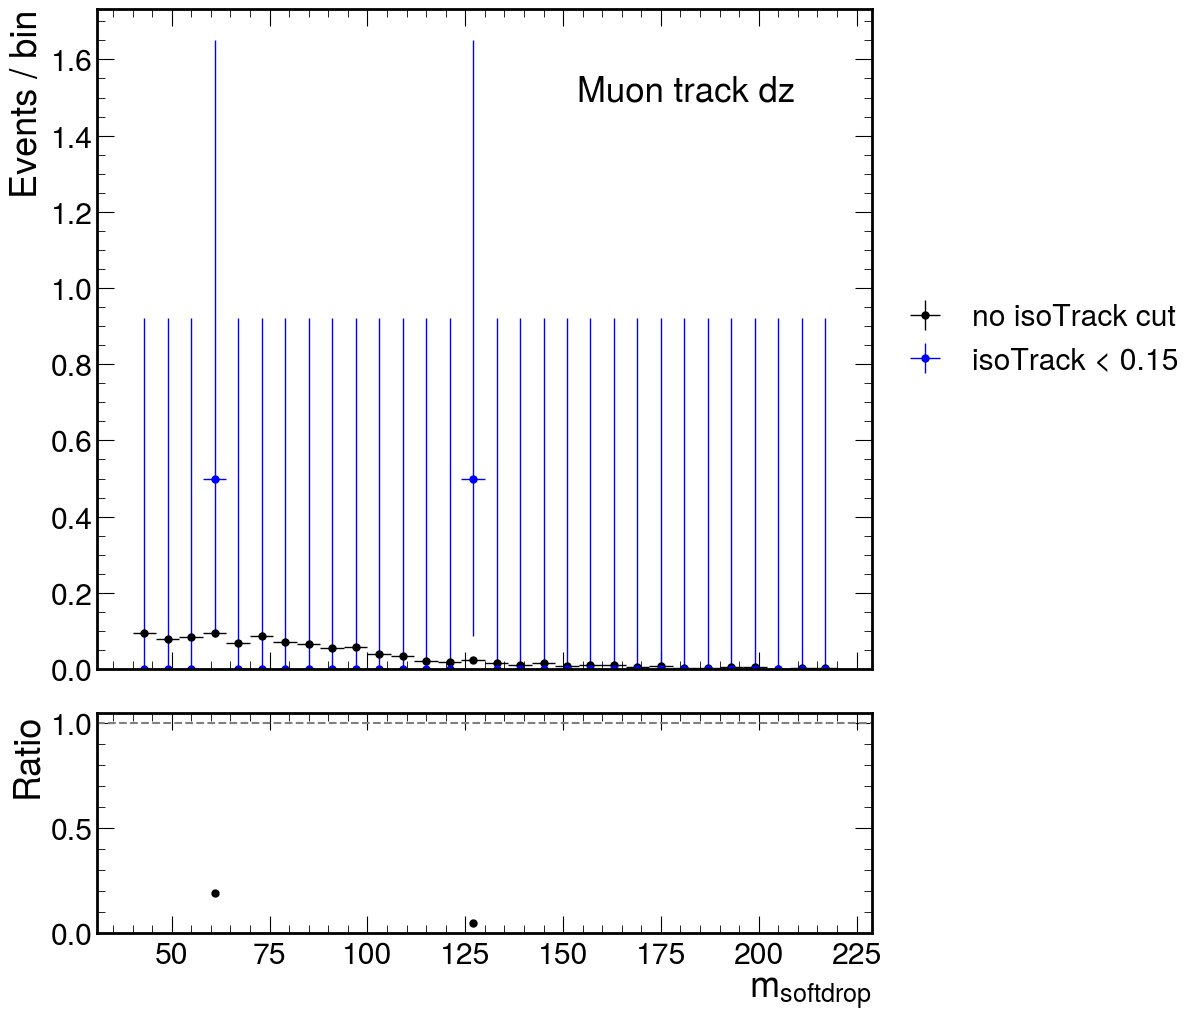

In [6]:
from coffea.hist import clopper_pearson_interval, poisson_interval

cuts = [
    'Nothing',
    'HLT_Mu50',
    'AK8 jet p$_T$ > 200',
    'MET $>$ 50 GeV',
    'Good muon',
    'Leptonic W p$_T$ > 150',
    'Same hem. AK4 b-jet',
    'Opp. hem. AK8 jet',
    'Muon track dz',
]

for i in h_isoTrack.axes["cut"]:

    fig, (ax, rax) = plt.subplots(
        2, 1, figsize=(10, 12), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
    )
    fig.subplots_adjust(hspace=0.1)
    ax.set_ylabel("Events / bin")
    rax.set_ylabel("Ratio")
    rax.set_xlabel(r"m$_{softdrop}$")
    ax.set_xlabel(" ")
    
    hh_old = h_old[{"cut" : hist.loc(i)}]
    hh_old *= 1 / hh_old.sum().value
    
    hh_isoTrack = h_isoTrack[{"cut" : hist.loc(i)}]
    hh_isoTrack  *= 1 / hh_isoTrack.sum().value
    
    mplhep.histplot(
        hh_old, 
        ax=ax, 
        histtype="errorbar",
        xerr=True,
        c="black",
        label=f"no isoTrack cut" # ({hh_old.sum().value:,.0f})"
    )
    
    mplhep.histplot(
        hh_isoTrack, 
        ax=ax, 
        histtype="errorbar",
        xerr=True,
        c="blue",
        label=f"isoTrack < 0.15" # ({hh_isoTrack.sum().value:,.0f})"
    )
    
    centers = hh_old.axes[0].centers
    sumw_num, sumw2_num = hh_old.values(), hh_old.variances()
    sumw_denom, sumw2_denom = hh_isoTrack.values(), hh_isoTrack.variances()
    
    rsumw = sumw_num / np.maximum(0, sumw_denom)
    rsumw_unc = poisson_interval(
        rsumw,
        sumw2_num / sumw_denom**2
    )
    
    data_err_opts = {
        'linestyle': 'none',
        'marker': '.',
        'markersize': 10.,
        'color': 'k',
        'elinewidth': 1,
    }
    
    rax.errorbar(
        centers,
        rsumw,
        #xerr=centers[1]-centers[0],
        #yerr=rsumw_unc,
        **data_err_opts,
    )
    
    rax.axhline(1, color='gray',ls='--')
    
    plt.text(0.9, 0.85, f"{cuts[i]}",
                fontsize=25,
                horizontalalignment='right',
                verticalalignment='bottom',
                transform=ax.transAxes
               )
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [3]:
mc = util.load("outfiles/Run3Summer22/lumi986/muoniso/cutflow_TTtoLNu2Q.coffea")
mc["cutflow"]

Hist(
  StrCategory(['TTtoLNu2Q'], growth=True, name='dataset', label='Dataset'),
  IntCategory([-2.14748e+09, 3, 2, 1], growth=True, name='cat', label='Category'),
  Regular(50, 40, 220, name='msoftdrop'),
  Regular(50, 150, 700, name='pt', label='$p_T$'),
  Regular(50, 0, 1, name='pn_Hbb', label='H(bb) vs QCD score'),
  IntCategory([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], growth=True, name='cut', label='Cut Idx'),
  storage=Weight()) # Sum: WeightedSum(value=2.5445e+07, variance=8.87062e+09) (WeightedSum(value=2.22664e+10, variance=7.57123e+12) with flow)

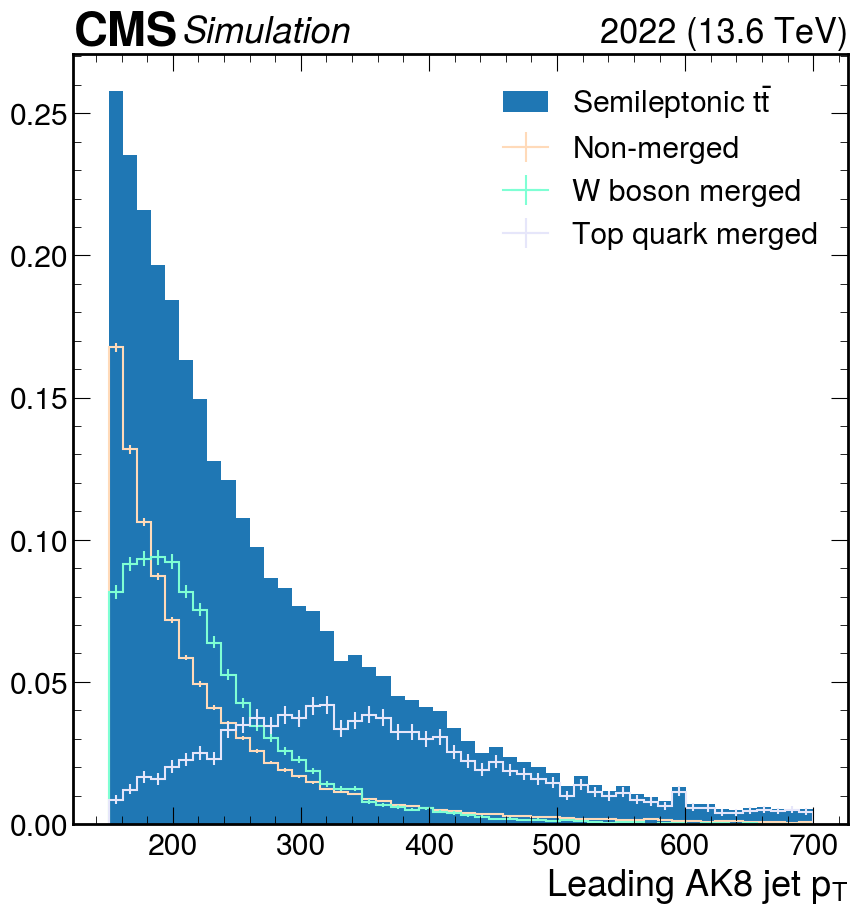

In [6]:
lumis = {
    "2022d" : 986.530469663
}
xs = {
    "TTtoLNu2Q" : 762.1,
    "QCD" : 222.1,
}
era = "2022d"

scale_lumi_mc = {k: xs[k] * lumis[era] / w for k, w in mc['sumw'].items()}

fig, ax = plt.subplots(figsize=(10, 10))

h_mc = mc["cutflow"].project("dataset", "pt", "cat", "cut")[{"cut" : hist.loc(1)}]

for i, name in enumerate(h_mc.axes["dataset"]):
    h_mc.view(flow=True)[i] *= scale_lumi_mc[name]
    
hh_mc = h_mc[{"dataset" : sum}]

non = hh_mc[{"cat" : hist.loc(3)}]
non *= 1 / non.sum().value
w = hh_mc[{"cat" : hist.loc(2)}]
w *= 1 / w.sum().value
top = hh_mc[{"cat" : hist.loc(1)}]
top *= 1 / top.sum().value

mplhep.histplot(
        [
            non,
            w,
            top
        ],
        ax=ax, 
        histtype="fill",
        stack=True,
        color=["#1f77b4", "#1f77b4", "#1f77b4"],
        label=[
            r"Semileptonic $t\bar{t}$", "", ""
        ],
    )

mplhep.histplot(
    [
     non, w, top
    ],
    ax=ax,
    label=["Non-merged", "W boson merged", "Top quark merged"],
    color=["peachpuff","aquamarine","lavender"]
)

mplhep.cms.label(
        ax=ax, 
        data=False, 
        #label="Private",
        year="2022",
        #lumi=f"{lumis[era]/1000:.2f}",
        com=13.6,
)

ax.set_xlabel(r"Leading AK8 jet $p_T$")
ax.legend(loc="best")
#ax.set_yscale('log')

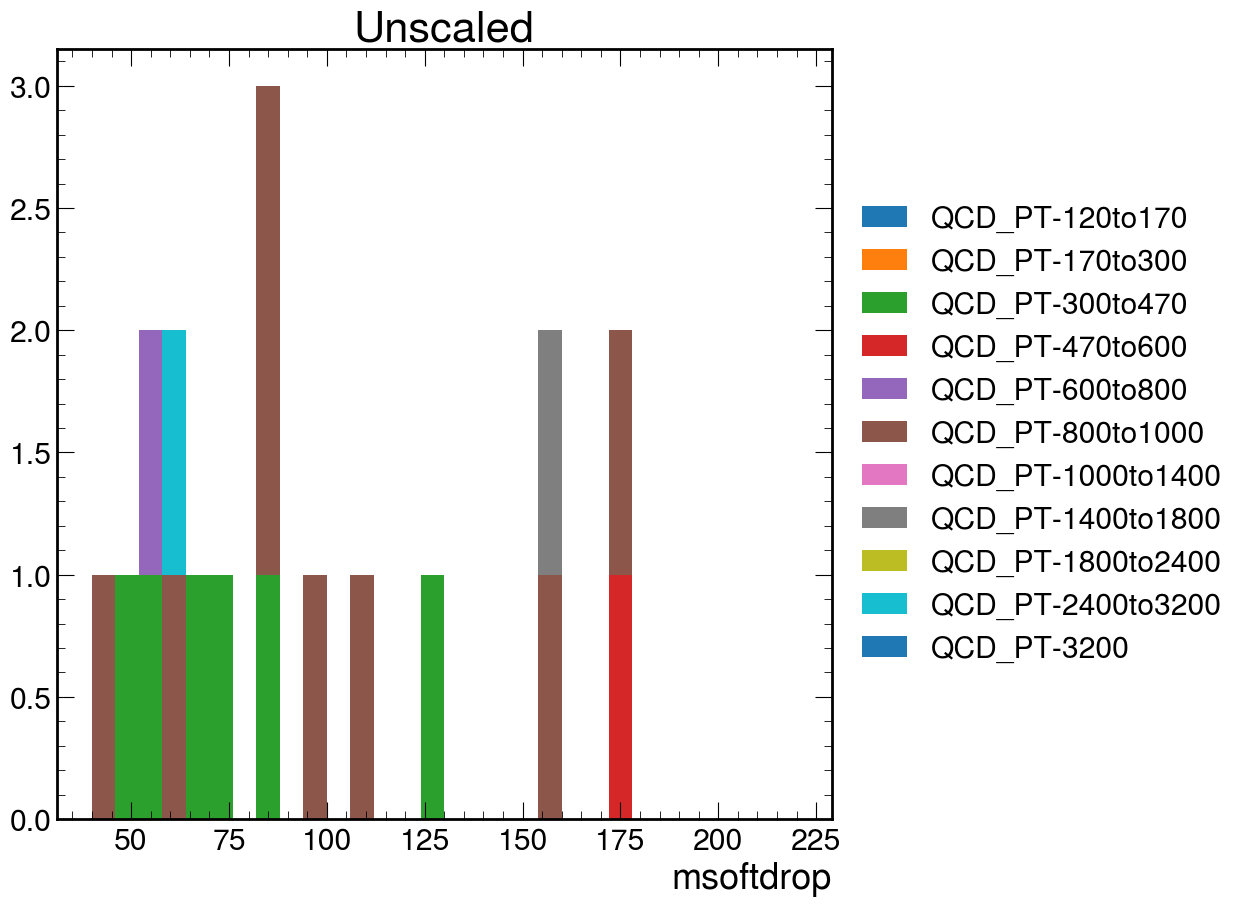

In [4]:
out=util.load("outfiles/Run3Summer22EE/fulllumi/nminus1_QCD_jetId_btag0p1.coffea")[0]

xs = {
    'QCD_PT-120to170' : 4.418e+05,
    'QCD_PT-170to300' : 1.125e+05,
    'QCD_PT-300to470' : 7.574e+03,
    'QCD_PT-470to600' : 6.271e+02,
    'QCD_PT-600to800': 1.795e+02,
    'QCD_PT-800to1000': 3.101e+01,
    'QCD_PT-1000to1400': 8.992e+00,
    'QCD_PT-1400to1800': 8.071e-01,
    'QCD_PT-1800to2400' : 1.167e-01,
    'QCD_PT-2400to3200': 7.624e-03,
    'QCD_PT-3200': 2.313e-0,
}

fig, ax = plt.subplots(figsize=(10, 10))

hs = []
for QCD in xs.keys():

    h = out["cutflow"][{
        "pn_Hbb" : slice(0j, 1j, sum),
        "region" : hist.loc("all"),
        "dataset" : hist.loc(QCD),
        "cat" : sum,
        "cut" : hist.loc(4),
    }]
    hs.append(h)
    
mplhep.histplot(
    hs,
    ax=ax, 
    histtype="fill",
    label=xs.keys(),
    stack=True,
)

ax.set_title("Unscaled")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

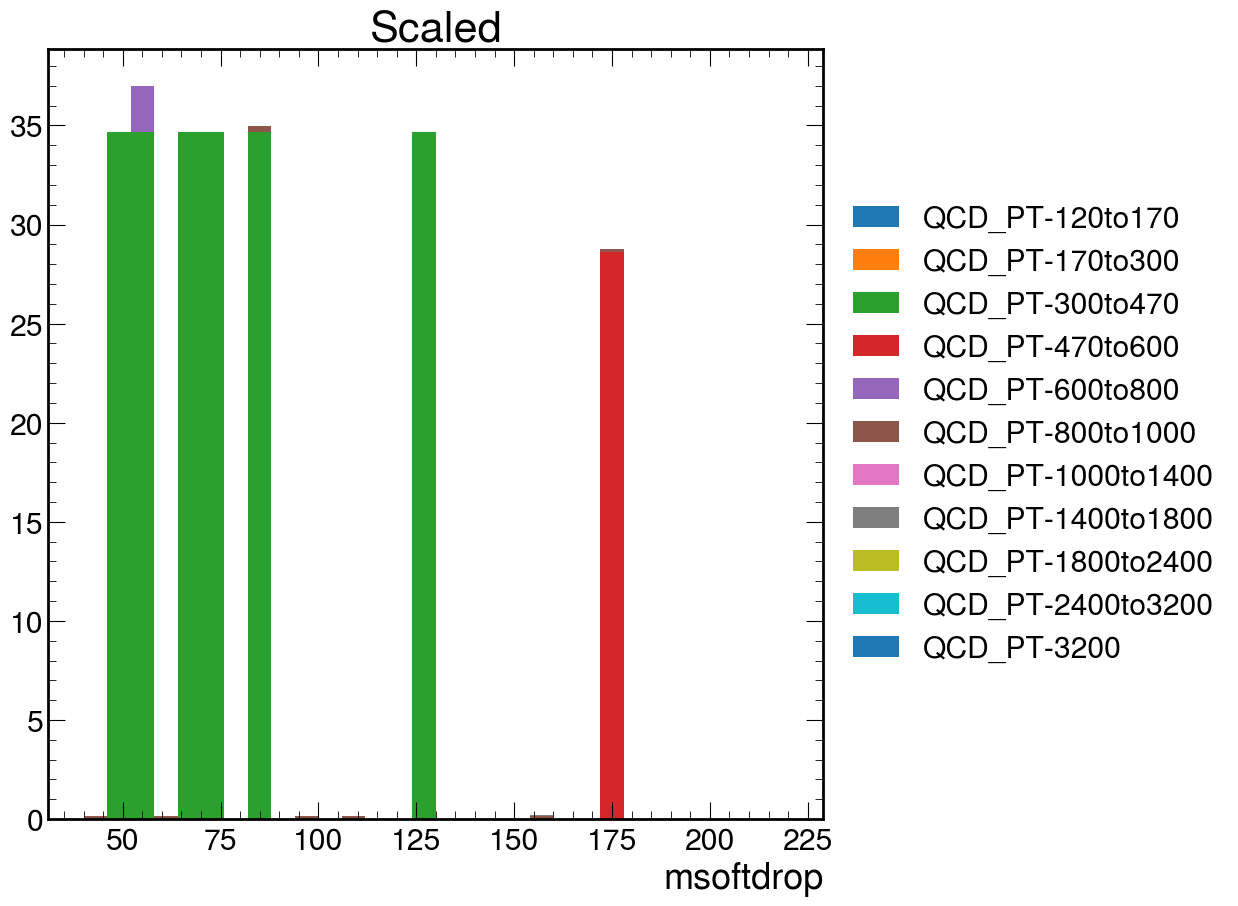

In [5]:
out=util.load("outfiles/Run3Summer22EE/fulllumi/nminus1_QCD_jetId_btag0p1.coffea")[0]

lumis = {
    "2022c&d" : 3820.82926407
}

scale = 1 #0.47837295482

xs = {
    'QCD_PT-120to170' : 4.418e+05,
    'QCD_PT-170to300' : 1.125e+05,
    'QCD_PT-300to470' : 7.574e+03,
    'QCD_PT-470to600' : 6.271e+02,
    'QCD_PT-600to800': 1.795e+02,
    'QCD_PT-800to1000': 3.101e+01,
    'QCD_PT-1000to1400': 8.992e+00,
    'QCD_PT-1400to1800': 8.071e-01,
    'QCD_PT-1800to2400' : 1.167e-01,
    'QCD_PT-2400to3200': 7.624e-03,
    'QCD_PT-3200': 2.313e-0,
}

era = "2022c&d"

scale_lumi = {k: xs[k] * lumis[era] * scale / w for k, w in out['sumw'].items()}

for i, name in enumerate(out["cutflow"].axes["dataset"]):
    out["cutflow"].view(flow=True)[i] *= scale_lumi[name]

fig, ax = plt.subplots(figsize=(10, 10))

hs = []
for QCD in xs.keys():

    h = out["cutflow"][{
        "pn_Hbb" : slice(0j, 1j, sum),
        "region" : hist.loc("all"),
        "dataset" : hist.loc(QCD),
        "cat" : sum,
        "cut" : hist.loc(4),
    }]
    hs.append(h)
    
mplhep.histplot(
    hs,
    ax=ax, 
    histtype="fill",
    label=xs.keys(),
    stack=True,
)

ax.set_title("Scaled")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

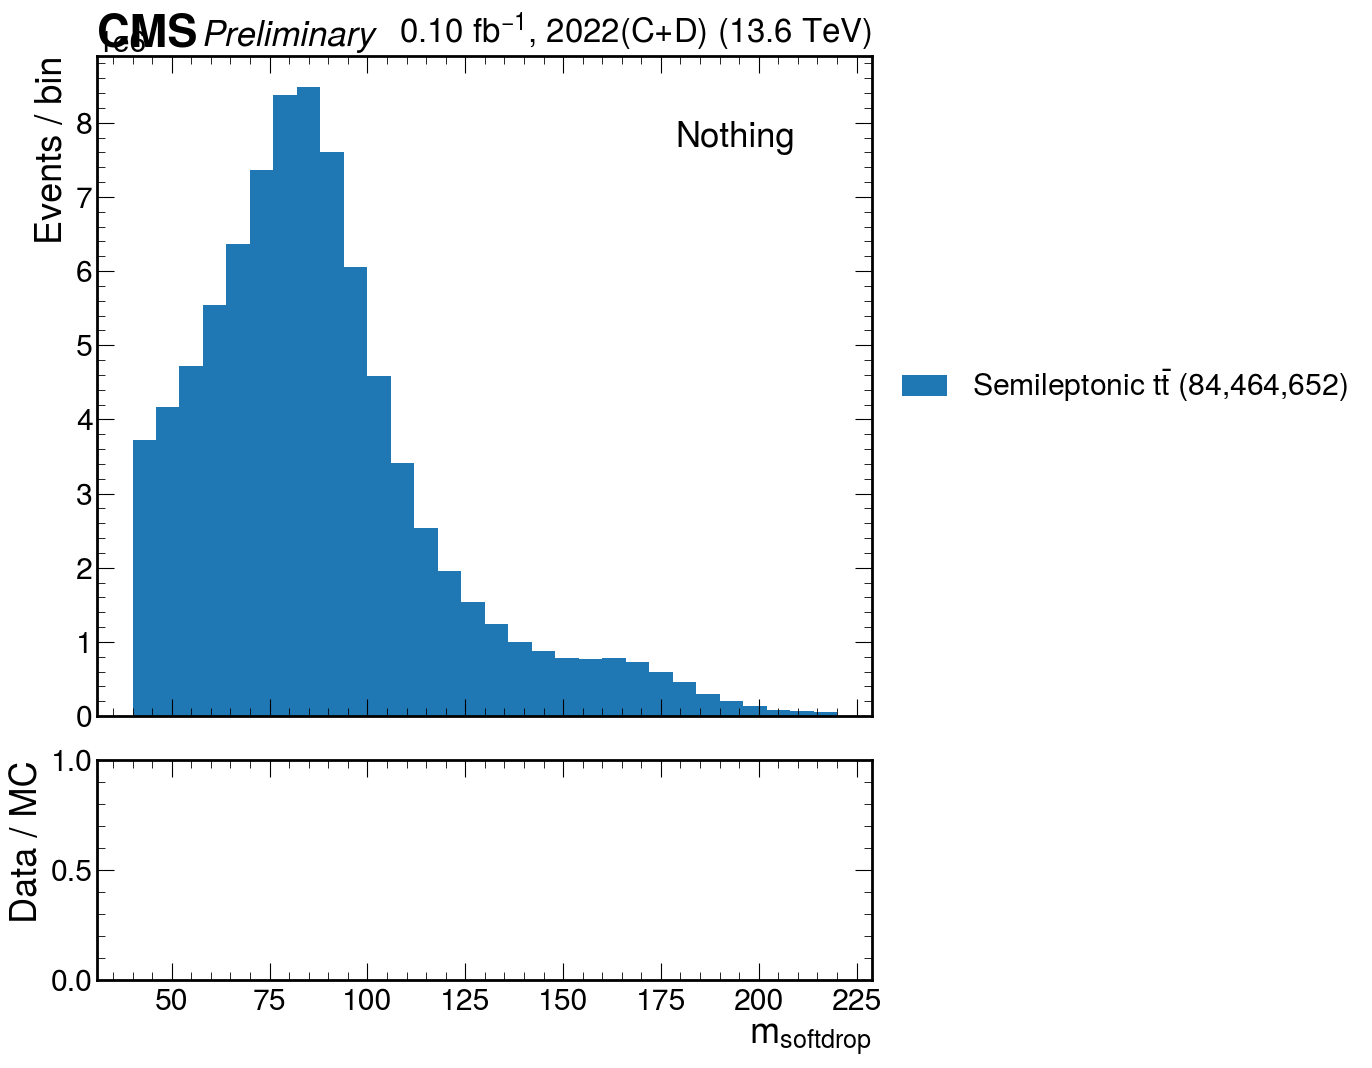

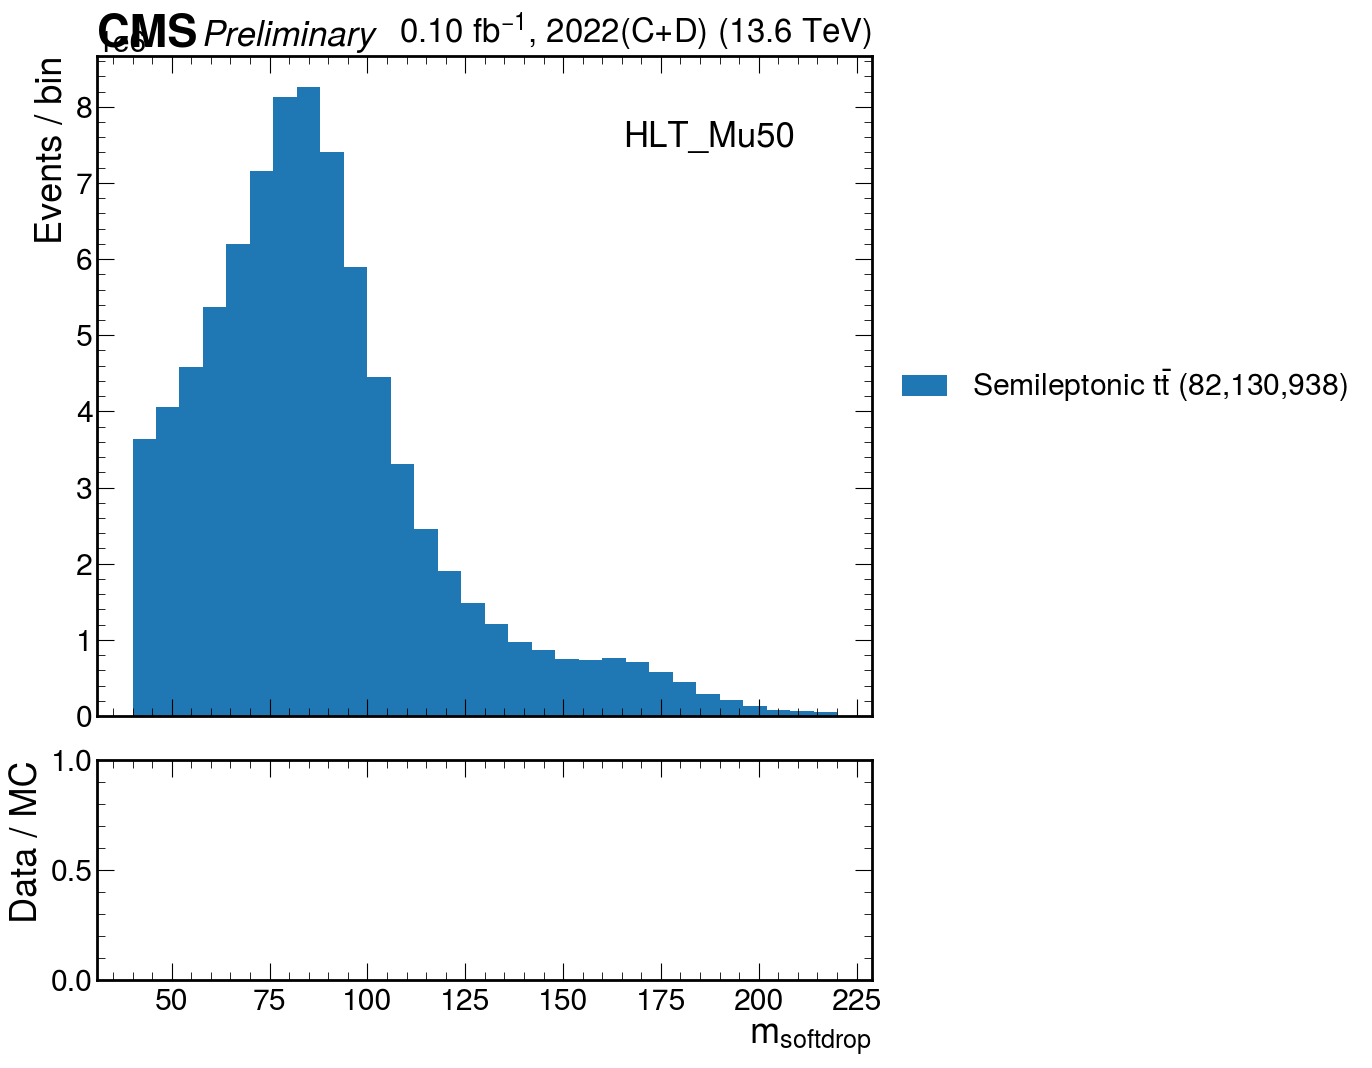

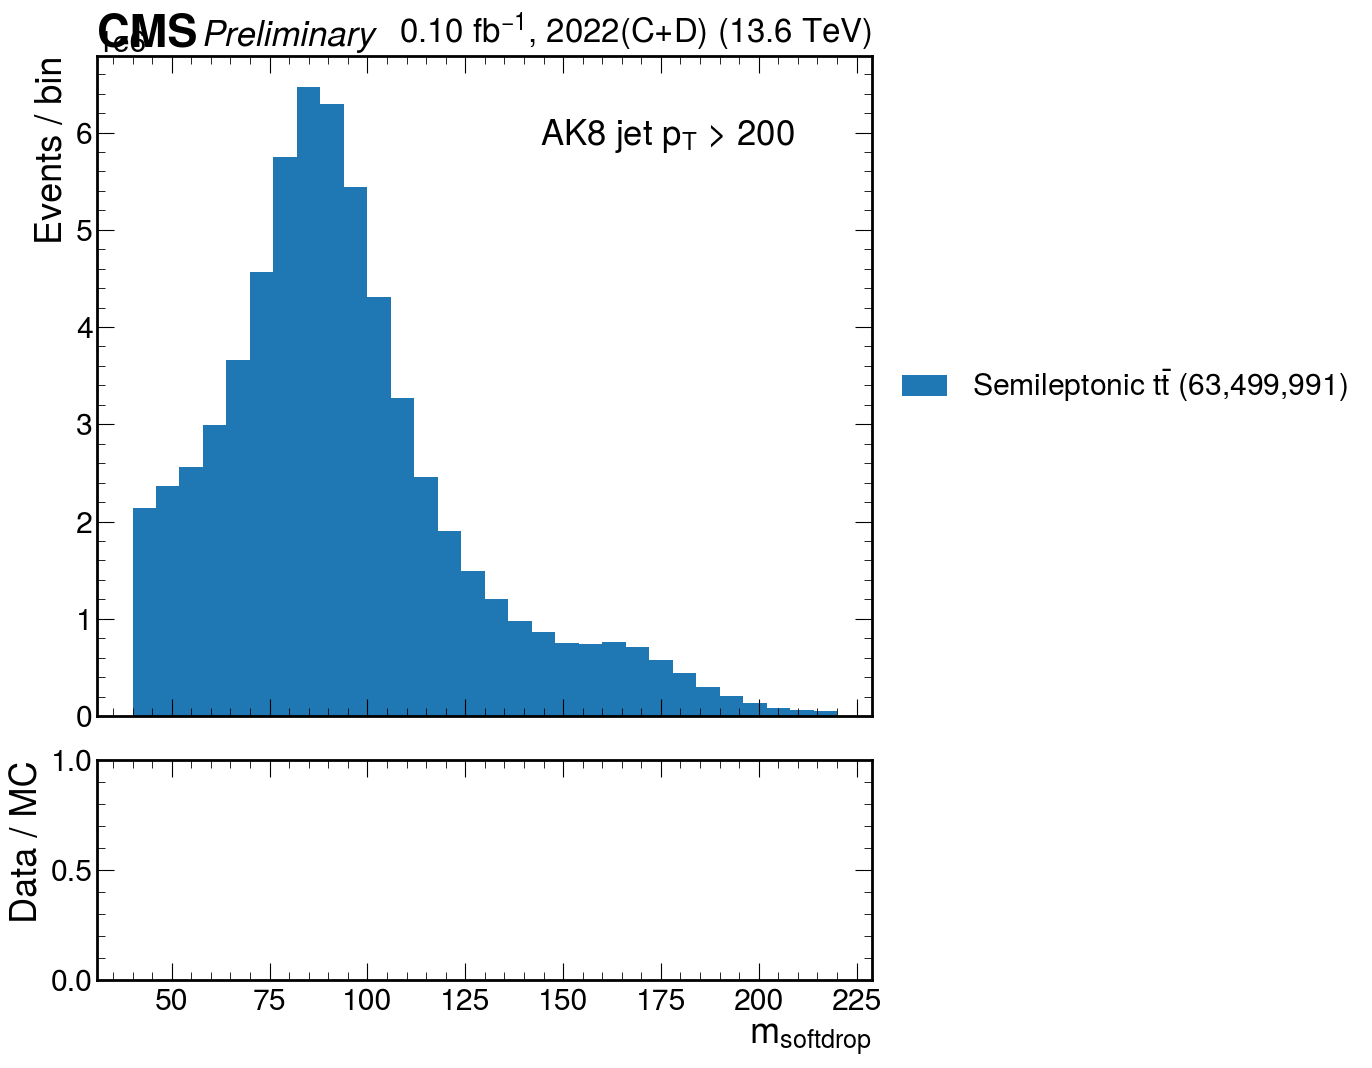

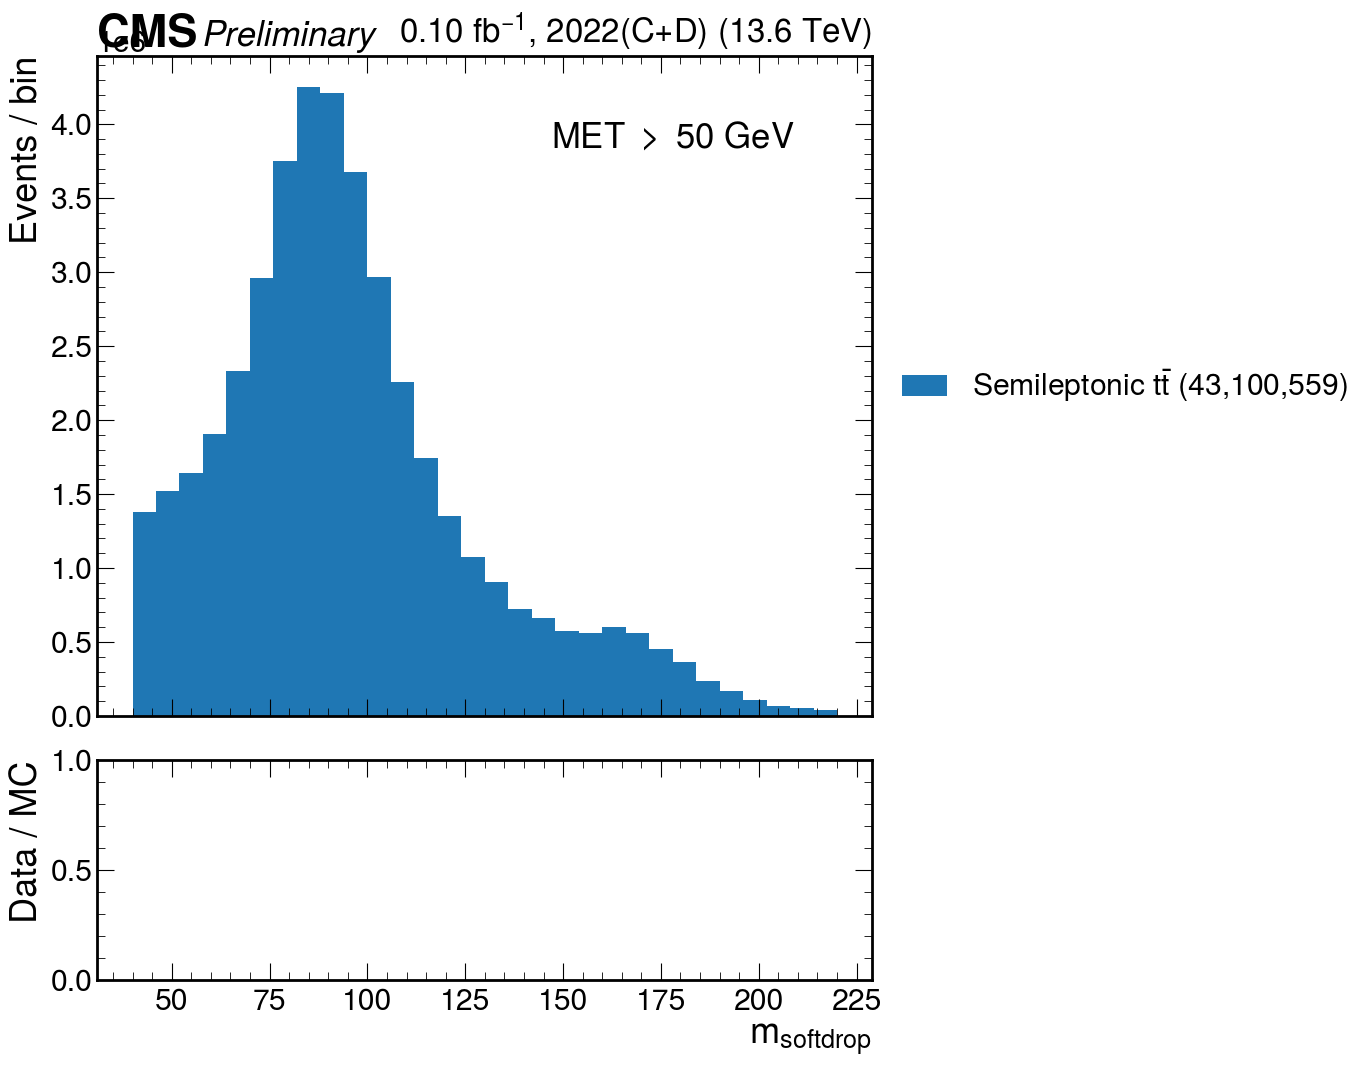

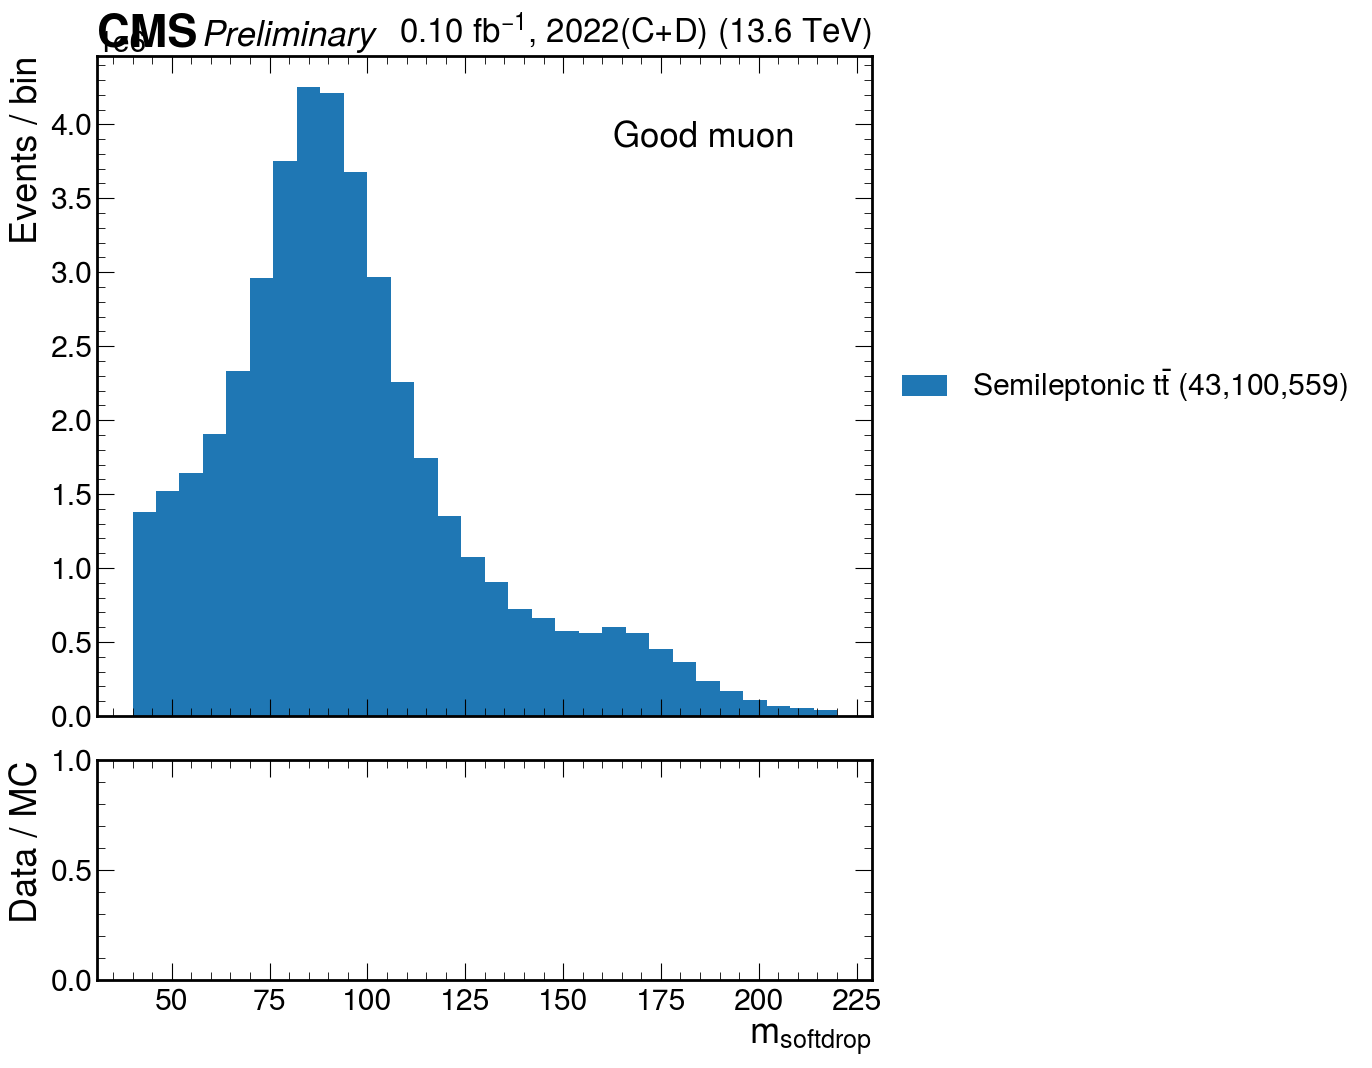

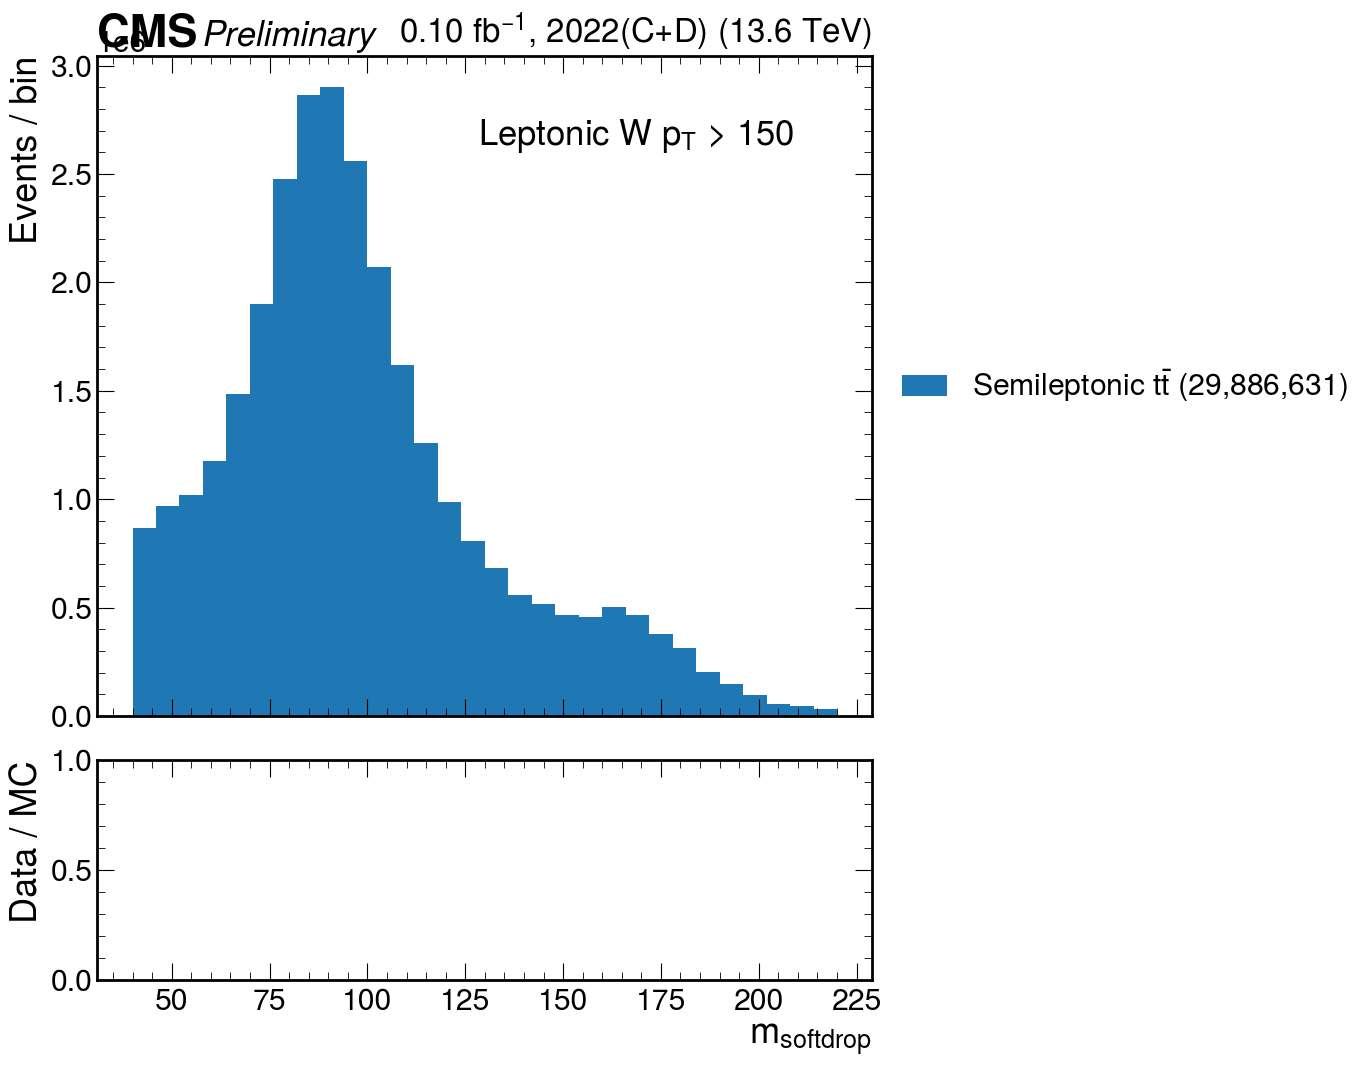

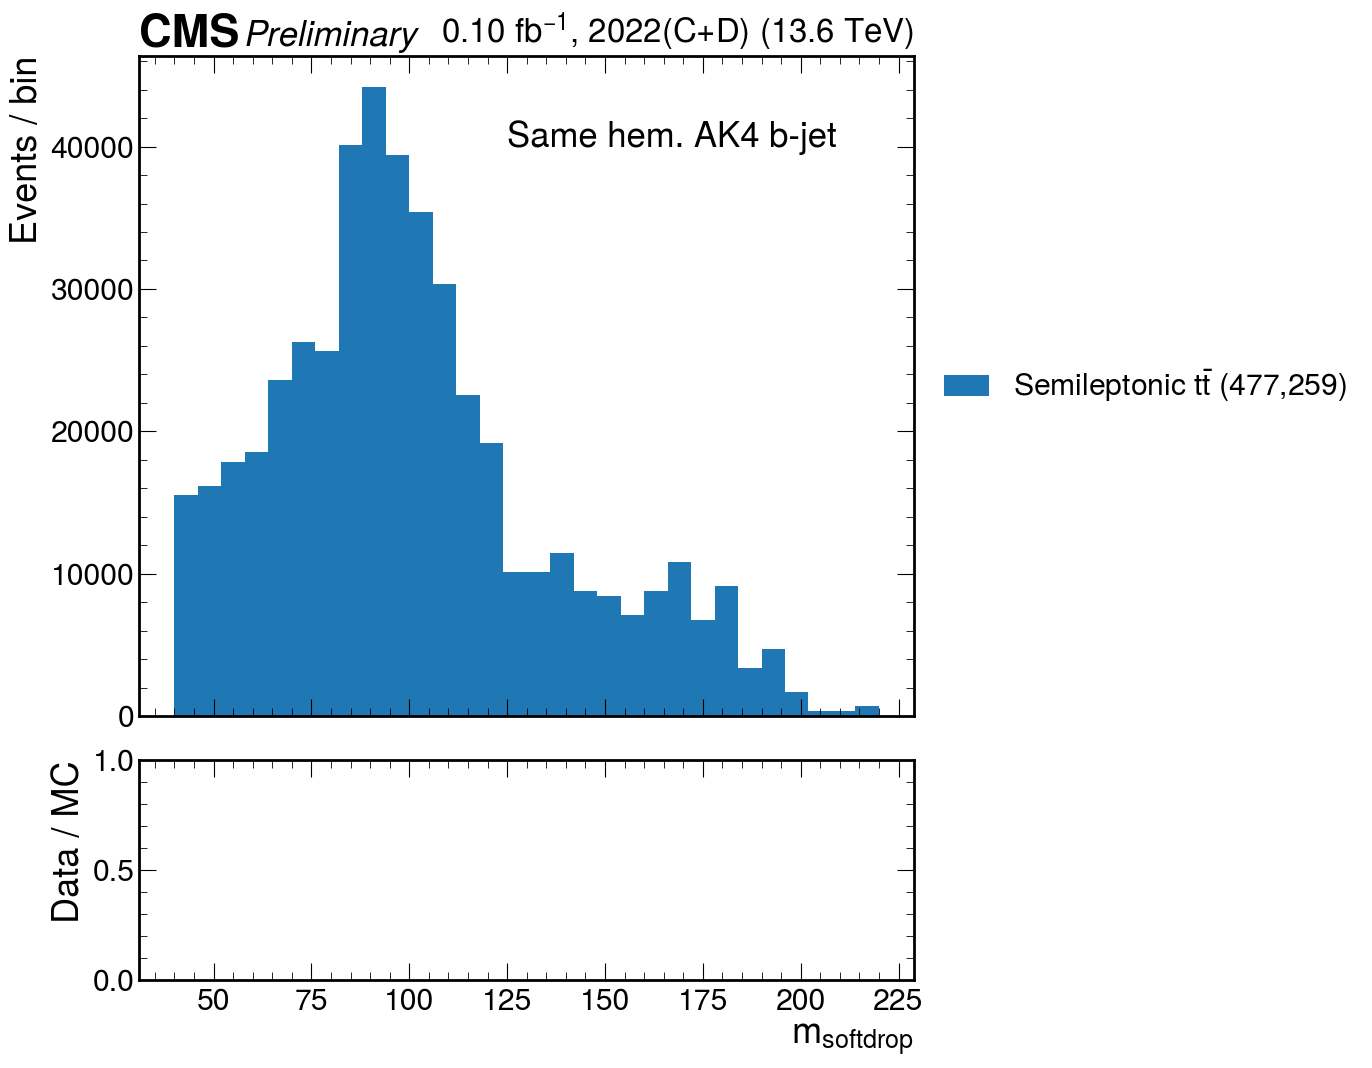

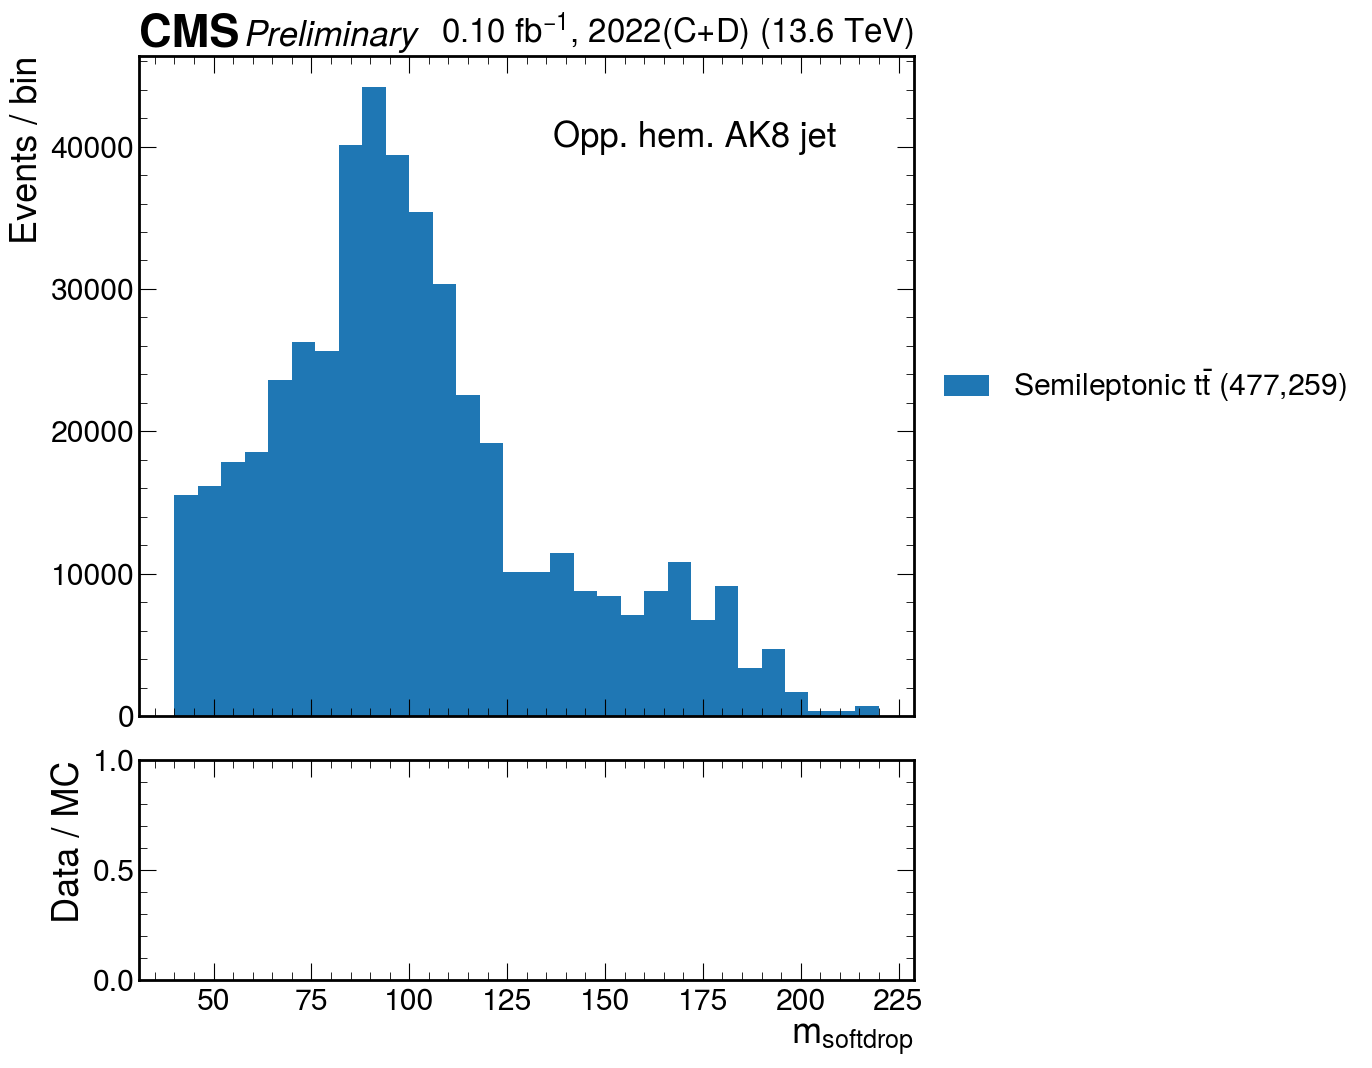

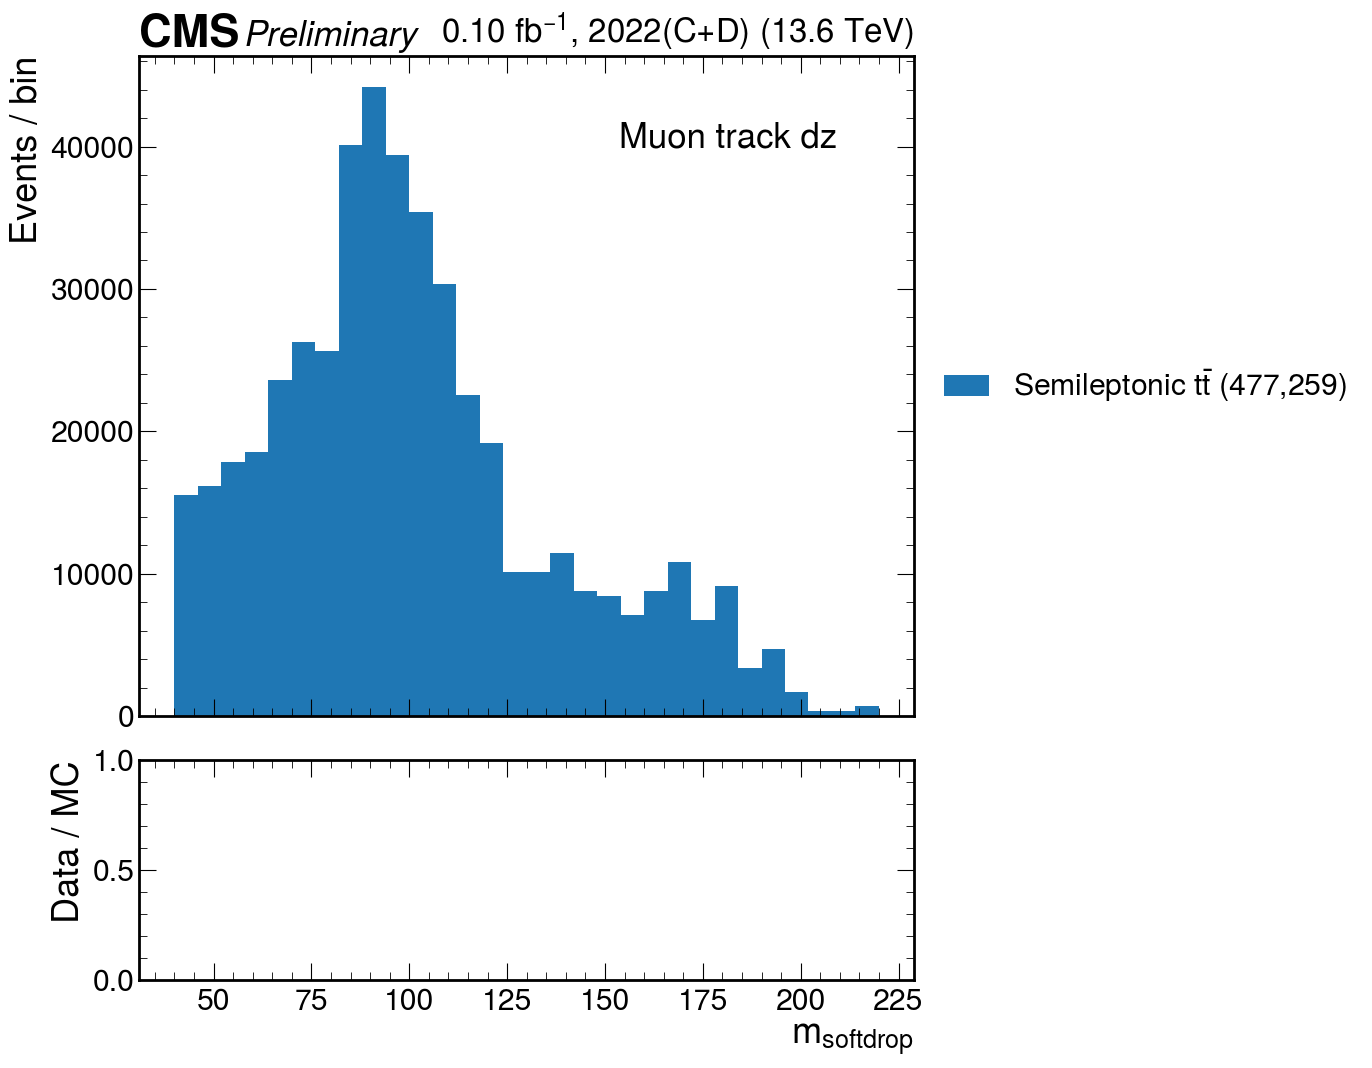

In [13]:
mc = util.load("outfiles/Run3Summer22EE/fulllumi/nminus1_TTtoLNu2Q_Run3Summer22EE_jetId_btag0p1.coffea")[0]

cuts = [
    'Nothing',
    'HLT_Mu50',
    'AK8 jet p$_T$ > 200',
    'MET $>$ 50 GeV',
    'Good muon',
    'Leptonic W p$_T$ > 150',
    'Same hem. AK4 b-jet',
    'Opp. hem. AK8 jet',
    'Muon track dz',
]

h_tt = mc["cutflow"][{
    "pn_Hbb" : slice(0j, 1j, sum),
    "region" : hist.loc("all"),
    "dataset" : sum,
}]

for i in h_tt.axes["cut"]:

    fig, (ax, rax) = plt.subplots(
        2, 1, figsize=(10, 12), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
    )
    fig.subplots_adjust(hspace=0.1)
    ax.set_ylabel("Events / bin")
    rax.set_ylabel("Data / MC")
    rax.set_xlabel(r"m$_{softdrop}$")
    ax.set_xlabel(" ")
    
    hh_tt = h_tt[{"cut" : hist.loc(i), "cat" : sum}]
    
    mplhep.histplot(
        [
            hh_tt, #[{"cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}],
        ],
        ax=ax, 
        histtype="fill",
        label=[
            r"Semileptonic $t\bar{t}$" + f" ({hh_tt.sum().value:,.0f})",
        ],
        stack=True,
        sort="y_r",
        color=["#1f77b4"],
        edgecolor="black",
    )
    
#     mplhep.histplot(
#         [
#             hh_tt[{"cat" : hist.loc(3)}],
#             hh_tt[{"cat" : hist.loc(2)}],
#             hh_tt[{"cat" : hist.loc(1)}],
#         ],
#         ax=ax,
#         label=[
#             "Non matched ({0:,.0f})".format(hh_tt[{"cat" : hist.loc(3)}].sum().value),
#             "W matched ({0:,.0f})".format(hh_tt[{"cat" : hist.loc(2)}].sum().value),
#             "Top matched ({0:,.0f})".format(hh_tt[{"cat" : hist.loc(1)}].sum().value),
#         ],
#         color=["peachpuff","aquamarine","lavender"]
#     )
    
    plt.text(0.9, 0.85, f"{cuts[i]}",
                fontsize=25,
                horizontalalignment='right',
                verticalalignment='bottom',
                transform=ax.transAxes
               )

    mplhep.cms.label(
            ax=ax, 
            data=True, 
            fontsize=25,
            label="Preliminary",
            year="2022(C+D)",
            lumi=f"{100/1000:.2f}",
            com=13.6,
        )
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

/opt/conda/lib/python3.8/site-packages/hist/basehist.py:324: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))
/opt/conda/lib/python3.8/site-packages/hist/basehist.py:324: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))
/opt/conda/lib/python3.8/site-packages/hist/basehist.py:324: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))
/opt/conda/lib/python3.8/site-packages/hist/basehist.py:324: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))
/opt/conda/lib/python3.8/site-packages/hist/basehist.py:324: UserWarning: List indexing selection is experimental. Removed bins are not plac

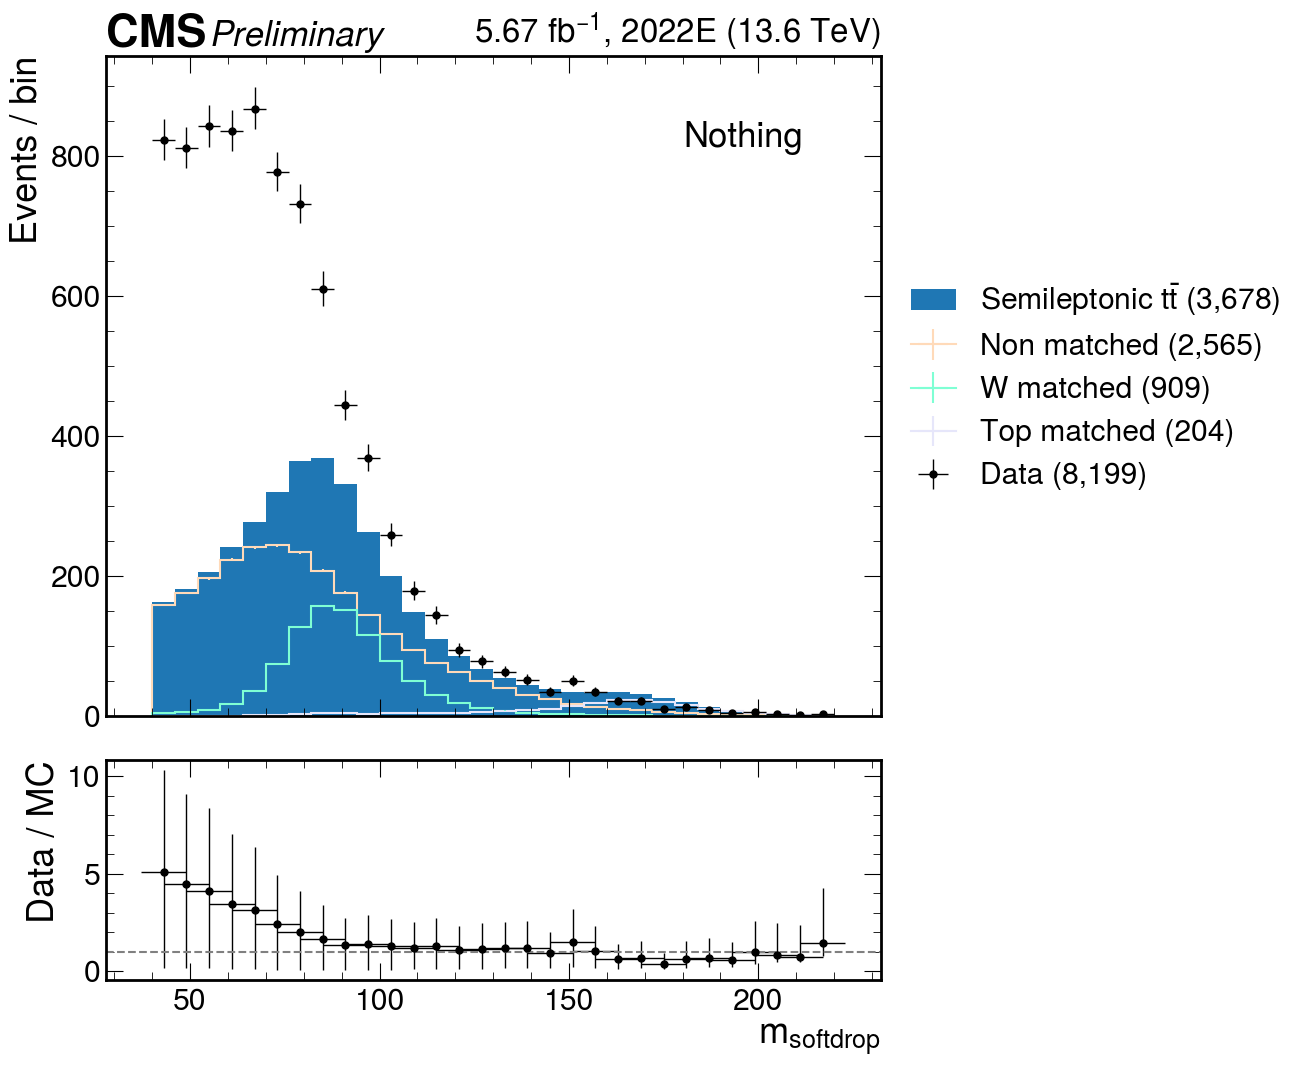

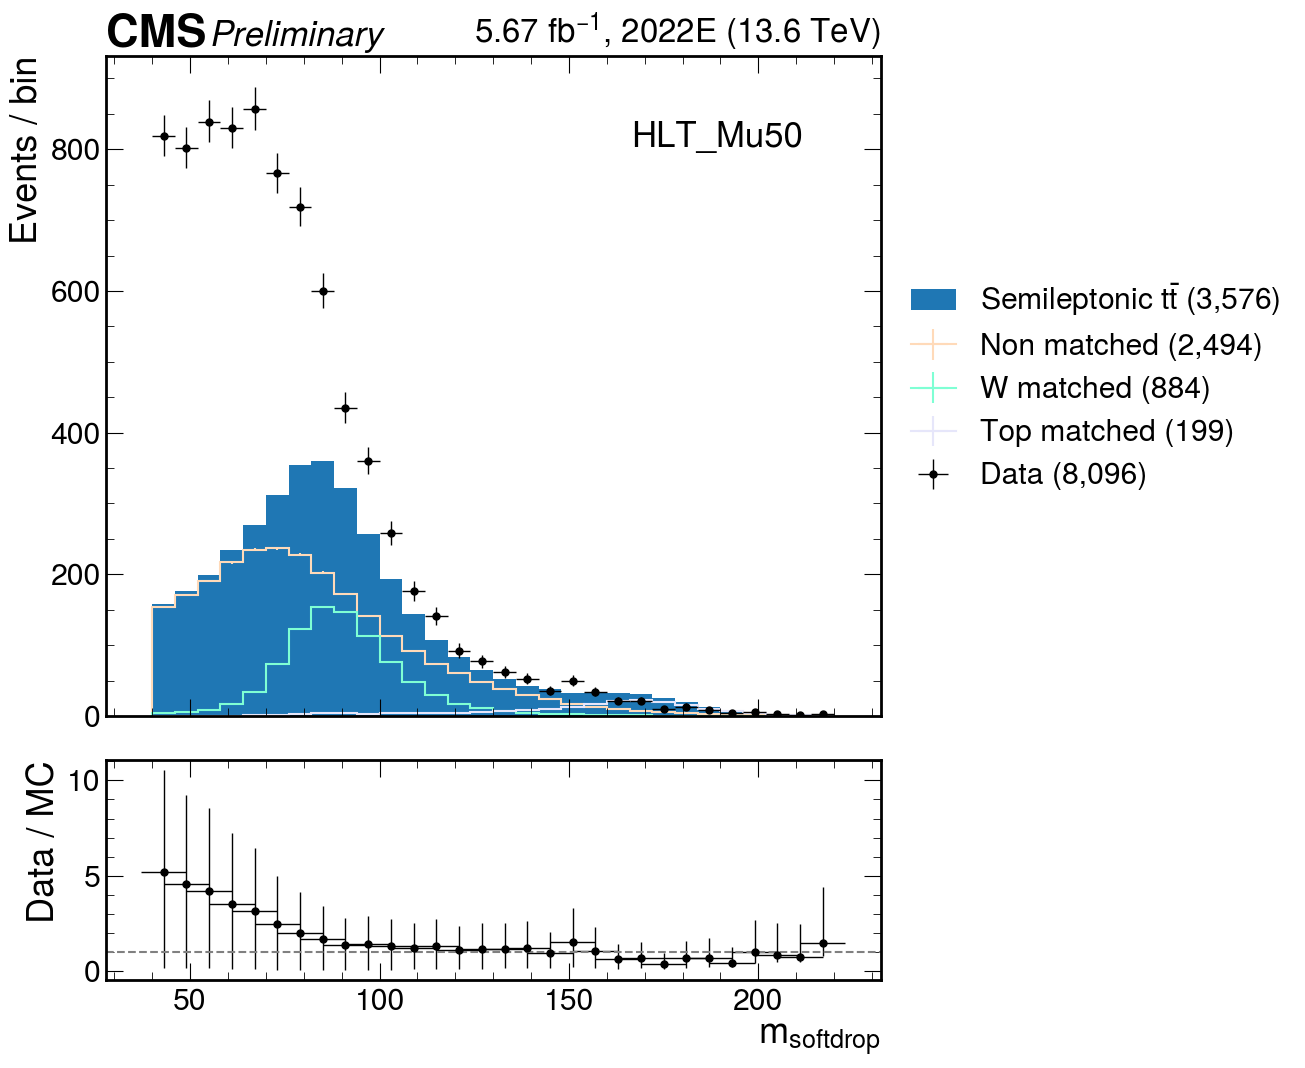

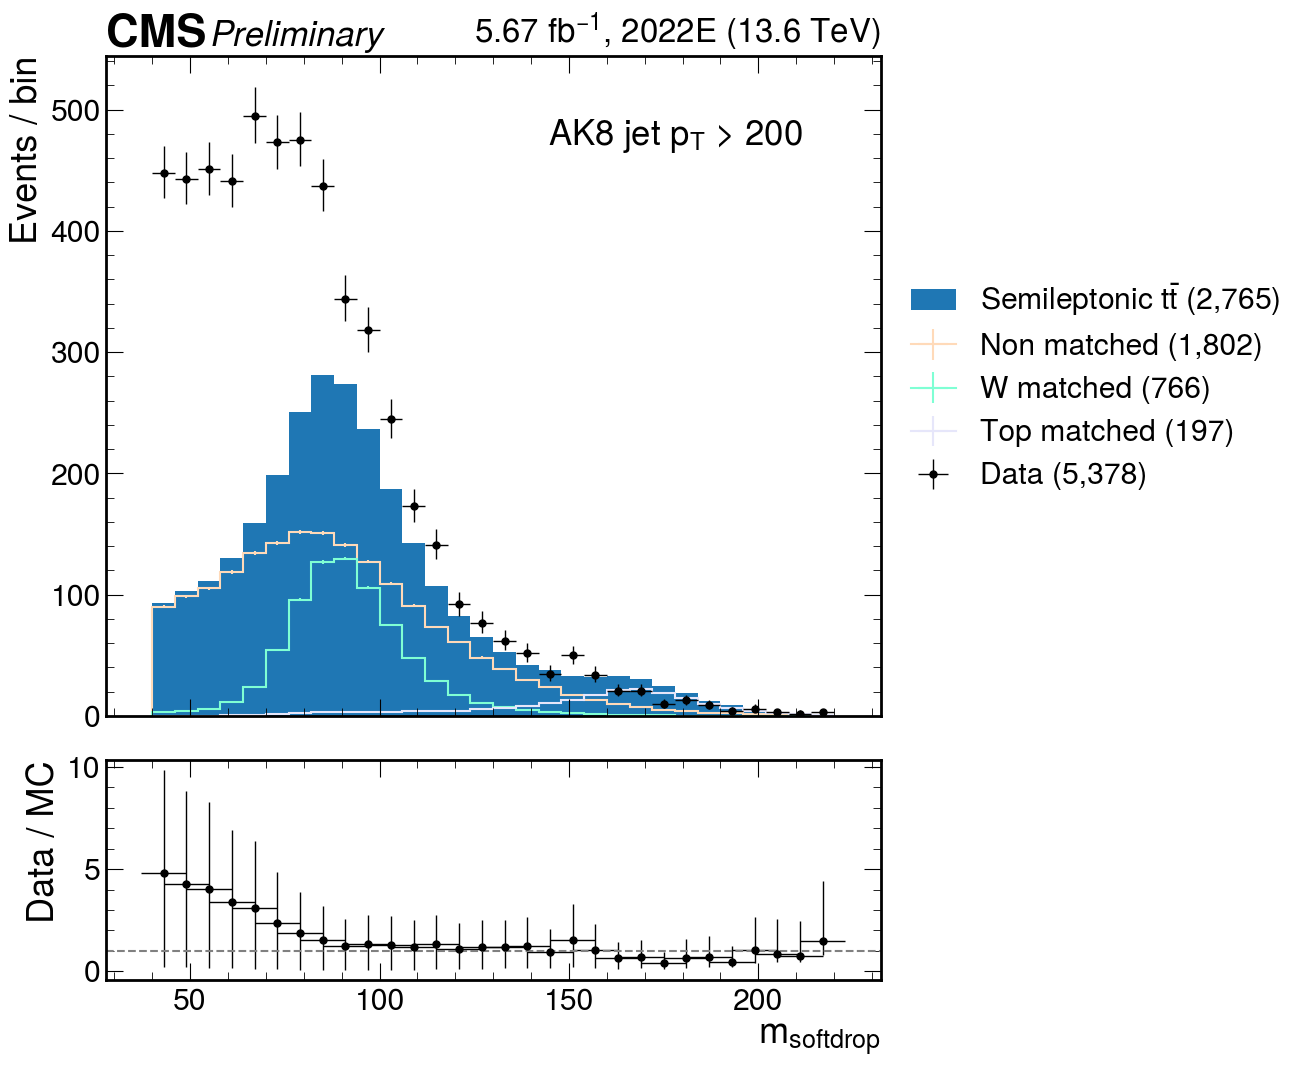

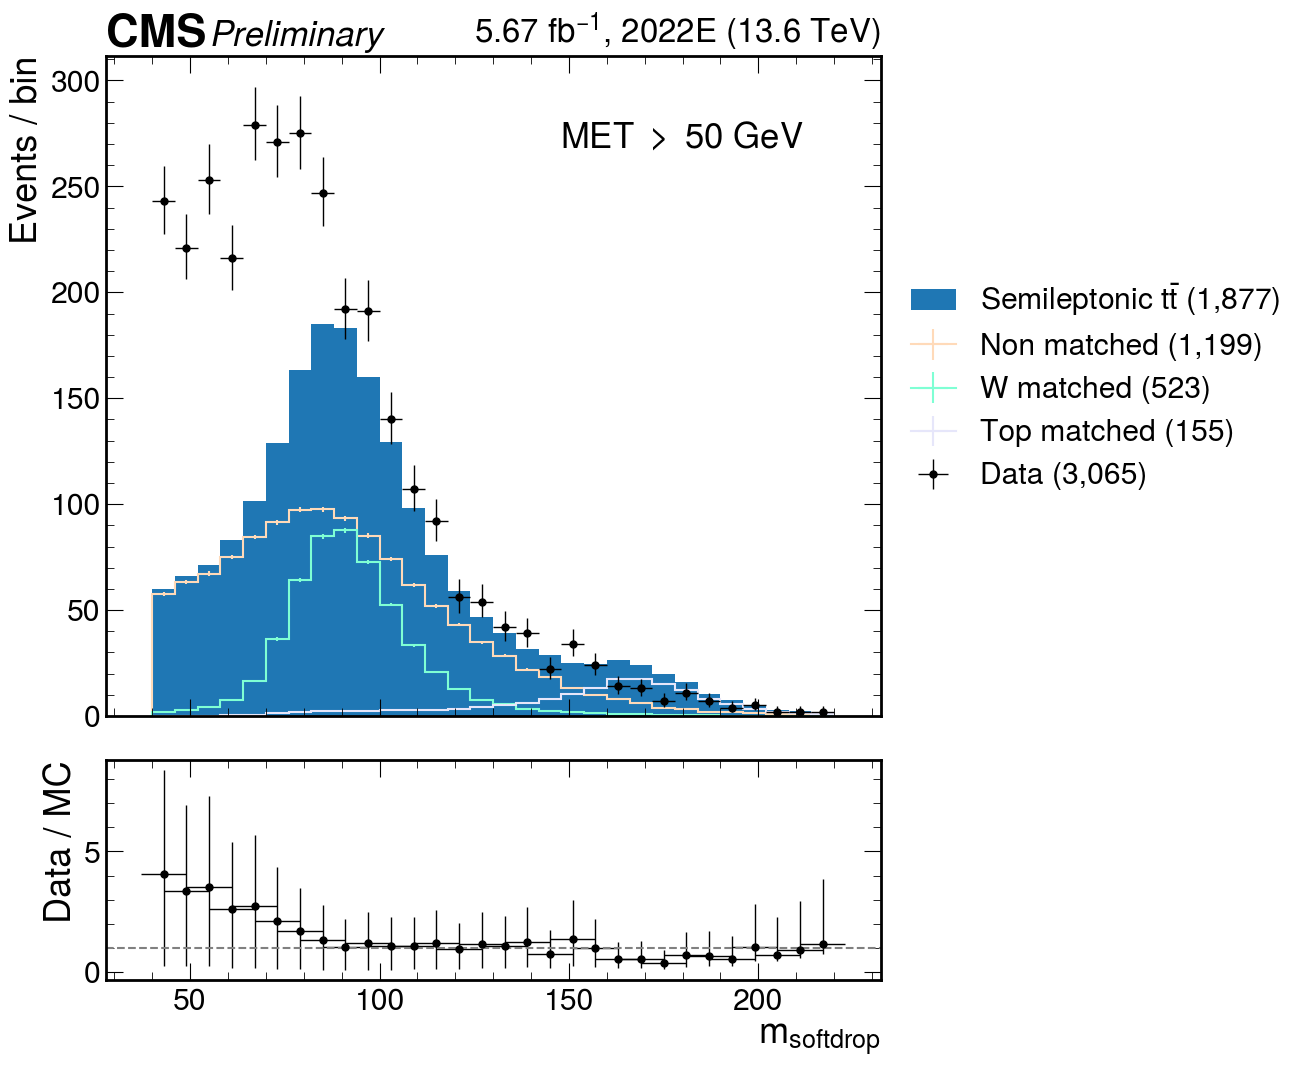

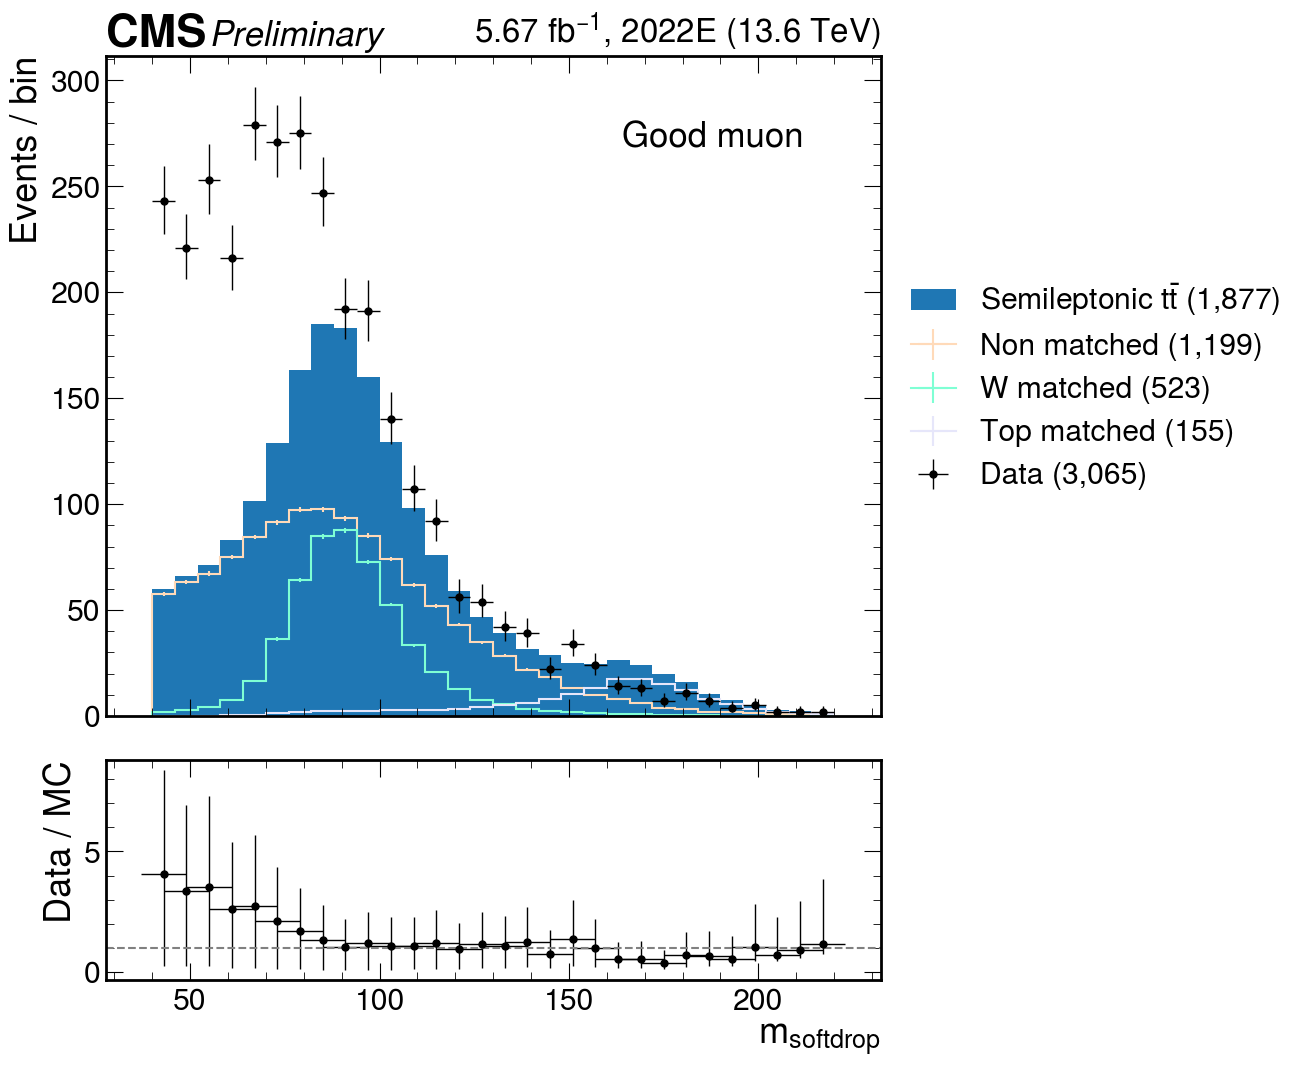

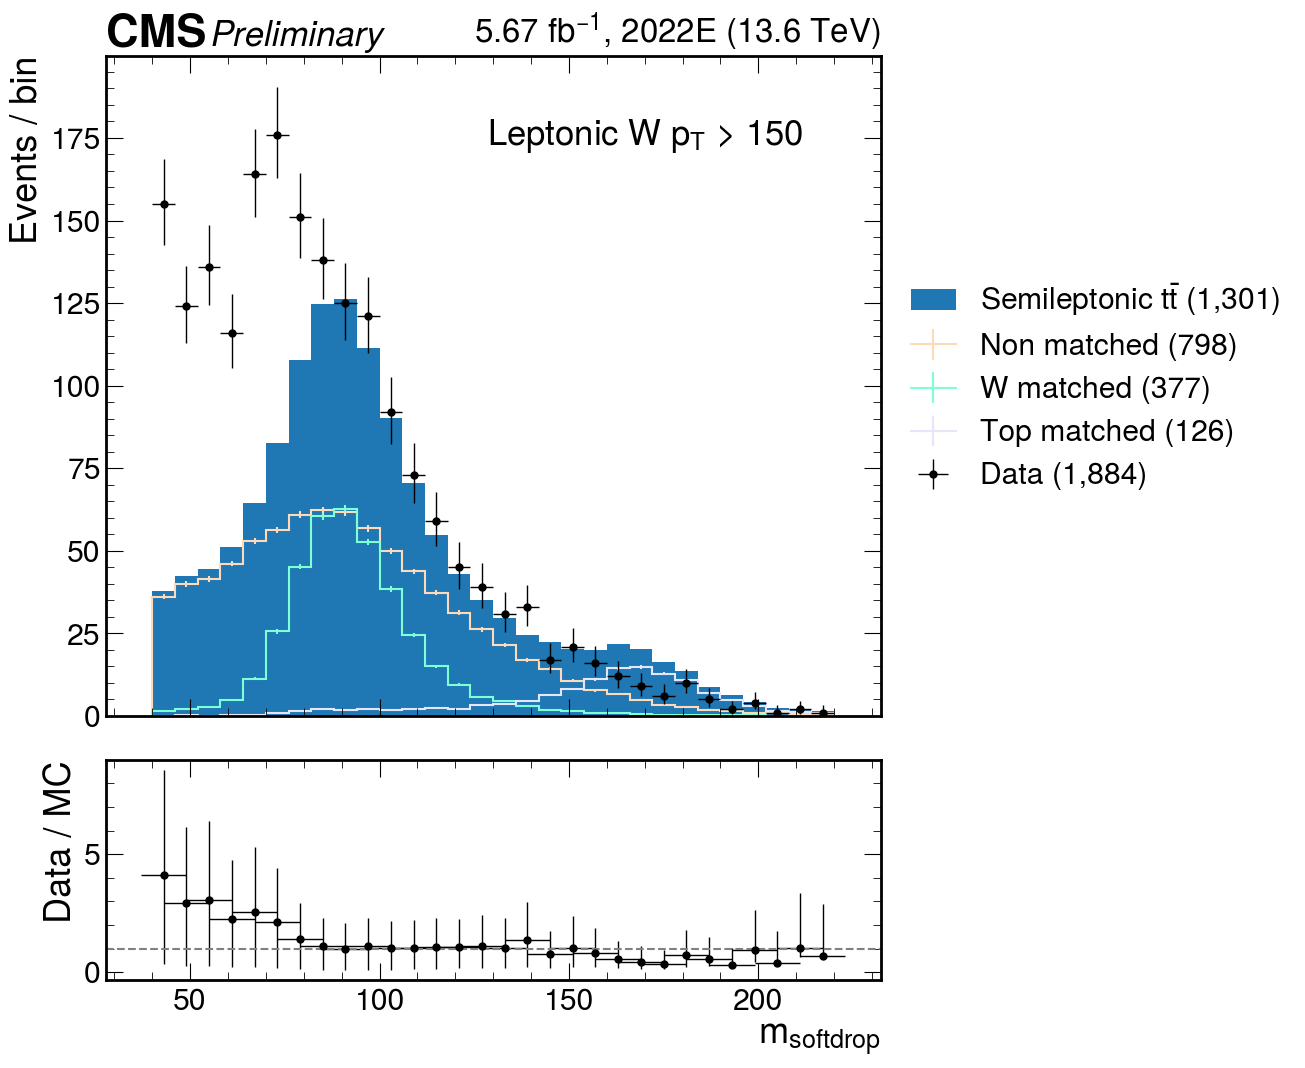

In [39]:
from coffea.hist import clopper_pearson_interval, poisson_interval
import pickle

mc = util.load("outfiles/Run3Summer22EE/fulllumi/nminus1_TTtoLNu2Q_jetId_btag0p1.coffea")[0]
data = util.load("outfiles/Run3Summer22EE/fulllumi/nminus1_Run3Summer22EE_HLT_Mu50_jetId_btag0p1.coffea")[0]["cutflow"]

lumis = {
    "2022e" : 3582.31000642
}
era = "2022e"
xs = {
    "TTtoLNu2Q" : 762.1,
}

scale_lumi = {k: xs[k] * lumis[era] / w for k, w in mc['sumw'].items()}

for i, name in enumerate(mc["cutflow"].axes["dataset"]):
    mc["cutflow"].view(flow=True)[i] *= scale_lumi[name]

cuts = [
    'Nothing',
    'HLT_Mu50',
    'AK8 jet p$_T$ > 200',
    'MET $>$ 50 GeV',
    'Good muon',
    'Leptonic W p$_T$ > 150',
    'Same hem. AK4 b-jet',
    'Opp. hem. AK8 jet',
    'Muon track dz',
]

h_data = data[{
    "pn_Hbb" : slice(0j, 1j, sum),
    "cat" : sum,
    "dataset" : sum,
    "region" : hist.loc("all")
}]
h_tt = mc["cutflow"][{
    "pn_Hbb" : slice(0j, 1j, sum),
    "region" : hist.loc("all"),
    "dataset" : sum,
}]

for i in range(0, 6): #h_data.axes["cut"]:

    fig, (ax, rax) = plt.subplots(
        2, 1, figsize=(10, 12), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
    )
    fig.subplots_adjust(hspace=0.1)
    ax.set_ylabel("Events / bin")
    rax.set_ylabel("Data / MC")
    rax.set_xlabel(r"m$_{softdrop}$")
    ax.set_xlabel(" ")
    
    hh_tt = h_tt[{"cut" : hist.loc(i)}]
    
    mplhep.histplot(
        [
            hh_tt[{"cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}],
        ],
        ax=ax, 
        histtype="fill",
        label=[
            r"Semileptonic $t\bar{t}$" + f" ({hh_tt.sum().value:,.0f})",
        ],
        stack=True,
        sort="y_r",
        color=["#1f77b4"],
        edgecolor="black",
    )
    
    mplhep.histplot(
        [
            hh_tt[{"cat" : hist.loc(3)}],
            hh_tt[{"cat" : hist.loc(2)}],
            hh_tt[{"cat" : hist.loc(1)}],
        ],
        ax=ax,
        label=[
            "Non matched ({0:,.0f})".format(hh_tt[{"cat" : hist.loc(3)}].sum().value),
            "W matched ({0:,.0f})".format(hh_tt[{"cat" : hist.loc(2)}].sum().value),
            "Top matched ({0:,.0f})".format(hh_tt[{"cat" : hist.loc(1)}].sum().value),
        ],
        color=["peachpuff","aquamarine","lavender"]
    )
    
    hh_data = h_data[{"cut" : hist.loc(i)}]
    
    mplhep.histplot(
        hh_data, 
        ax=ax, 
        histtype="errorbar",
        xerr=True,
        c="black",
        label=f"Data ({hh_data.sum().value:,.0f})"
    )
    
    centers = hh_data.axes[0].centers
    sumw_num, sumw2_num = hh_data.values(), hh_data.variances()
    sumw_denom, sumw2_denom = hh_tt[{"cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}].values(), hh_tt[{"cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}].variances()
    
    rsumw = sumw_num / np.maximum(1, sumw_denom)
    rsumw_unc = poisson_interval(
        rsumw,
        sumw2_num / sumw_denom**2
    )
    
    data_err_opts = {
        'linestyle': 'none',
        'marker': '.',
        'markersize': 10.,
        'color': 'k',
        'elinewidth': 1,
    }
    
    rax.errorbar(
        centers,
        rsumw,
        xerr=centers[1]-centers[0],
        yerr=rsumw_unc,
        **data_err_opts,
    )
    
    rax.axhline(1, color='gray',ls='--')
    
    plt.text(0.9, 0.85, f"{cuts[i]}",
                fontsize=25,
                horizontalalignment='right',
                verticalalignment='bottom',
                transform=ax.transAxes
               )

    mplhep.cms.label(
            ax=ax, 
            data=True, 
            fontsize=25,
            label="Preliminary",
            year="2022E",
            lumi=f"{5.672:.2f}",
            com=13.6,
        )
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))